In [173]:
import os
import numpy as np
import astropy.table as Table
import astropy.units as unit
import astropy.constants as cons
from astropy.io import fits
from astropy.table import Table
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.coordinates as coord
from astroquery.gaia import Gaia
import warnings
from pyia import GaiaData
from matplotlib.patches import Ellipse
#import mpld3
from astropy.coordinates import (ICRS, GalacticLSR, CartesianDifferential, CartesianRepresentation, Galactocentric)
import stilism_extinction as stil
from scipy import optimize
from scipy.interpolate import UnivariateSpline
import datetime
import time
import ratelimiter as RL
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import UnivariateSpline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io.votable import parse

from astropy.time import Time
import multiprocessing as mp
# #Below settings for presentation figs
# import seaborn.apionly as sns
# sns.set_context('paper')
# plt.rcParams['savefig.dpi']=800
# plt.rcParams['ytick.labelsize']='large'
# plt.rcParams['xtick.labelsize']='large'
# plt.rcParams['axes.labelsize']=20
# plt.rcParams['figure.figsize']=(12.8,9.6)

#plt.style.use('HCH_plotstyle')
#%matplotlib inline
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#from cycler import cycler
#plt.rcParams['axes.prop_cycle'] = cycler(color=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7'])
# plt.rcParams["font.weight"] = "bold"
plt.rcParams['figure.figsize']=(2*3.35,2*.75*3.35)
#plt.rcParams['figure.dpi']=150
# plt.rcParams['font.size']=20
# plt.rcParams['font.family']='serif'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']='True'
plt.rcParams['ytick.minor.visible']='True'

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [24]:
def fix_qatar_names(df):
    nonnull=df
    for i,sys in df.iterrows():
        if 'Qatar-' in sys.pl_hostname:
            df.loc[i, 'pl_hostname']='Qatar '+sys.pl_hostname[6:]
    return df

def epoch_prop(df, to_epoch, current_epoch=2015.5):
    c=SkyCoord(ra=df['ra'].values*unit.deg,\
              dec=df['dec'].values*unit.deg,\
              distance=df['distance'].values*unit.pc,\
              pm_ra_cosdec=df['pmra'].values*unit.mas/unit.yr,\
              pm_dec=df['pmdec'].values*unit.mas/unit.yr,\
              obstime=Time(np.ones(len(df))*current_epoch, format='decimalyear'))
    c_epoch_prop=c.apply_space_motion(Time(to_epoch, format='decimalyear'))
    print(c_epoch_prop)
    df['ra_prop']=c_epoch_prop.ra
    df['dec_prop']=c_epoch_prop.dec
    return df

def load_dr25_usps(gaia_ids=True,  candidate_only=True, koi_score_cut=False):
    os.system('./DR25USPQuery.sh')
    dr25usps = pd.read_csv('DR25USPs.txt')
    dr25usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    dr25usps['KIC']=dr25usps['kepid'].astype(str)
    if koi_score_cut:
        dr25usps=dr25usps.loc[dr25usps.koi_score>0.68]
    if candidate_only:
        dr25usps=dr25usps.loc[((dr25usps.koi_disposition=='CANDIDATE')|(dr25usps.koi_disposition=='CONFIRMED'))]
    dr25usps=dr25usps.loc[dr25usps.koi_period<1]
    dr25usps['pl_orbper'] = dr25usps.koi_period
    dr25usps['pl_orbsmax'] = dr25usps.koi_sma
    dr25usps['pl_hostname'] = 'KIC '+dr25usps.KIC
    dr25usps=dr25usps[['pl_hostname','pl_orbper','pl_orbsmax','koi_score', 'koi_disposition']]
    dr25usps=fix_qatar_names(dr25usps)
    if gaia_ids:
        get_gaia_id_usps(dr25usps)
    return dr25usps

def load_confirmed_usps(gaia_ids=True):
    os.system('./ConfirmedUSPQuery.sh')
    confirmed_usps = pd.read_csv('confirmedUSPs.txt')
    confirmed_usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    confirmed_usps=confirmed_usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    confirmed_usps=fix_qatar_names(confirmed_usps)
    confirmed_usps=confirmed_usps.loc[confirmed_usps.pl_orbper<1]
    if gaia_ids:
        get_gaia_id_usps(confirmed_usps)
    return confirmed_usps

def load_non_kep_usps(gaia_ids=True):
    os.system('./NonKeplerUSPQuery.sh')
    nonkep_usps = pd.read_csv('nonkeplerUSPs.txt')
    nonkep_usps.rename(index=str,columns = {'ra':'ra_nasa','dec':'dec_nasa'}, inplace = True)
    nonkep_usps=nonkep_usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    nonkep_usps=nonkep_usps.loc[nonkep_usps.pl_orbper<1]
    nonkep_usps=fix_qatar_names(nonkep_usps)
    if gaia_ids:
        get_gaia_id_usps(nonkep_usps)
        nonkep_usps.loc[nonkep_usps.pl_hostname=='KELT-16','gaia_id']='Gaia DR2 1864885215233116032'
    return nonkep_usps

def load_so_usps(gaia_ids=True):
    sousps = Table.read('../Data/SanchisOjedaTable1.fit')
    sousps = sousps.to_pandas()
    sousps['KIC'] = sousps.KIC.str.decode('utf-8')
    sousps['pl_orbper'] = sousps.Porb
    sousps['pl_orbsmax'] = sousps.a_R_*sousps.R_*cons.R_sun.to('au')
    sousps['pl_hostname'] = 'KIC '+sousps.KIC
    sousps=fix_qatar_names(sousps)
    if gaia_ids:
        get_gaia_id_usps(sousps)
    return sousps

def load_k2_usps(gaia_ids=True):
    k2usps=pd.read_csv('K2USP_10806/planet_table_machine.txt'\
                   , na_values=' ',index_col=False,header=None, skiprows=1\
                   , names=['Candidate','Campaign','Period','Period_errup','Period_errdn','t_0',\
                            't_0_errup','t_0_errdn','Duration','Duration_errup','Duration_errdn',\
                            'Depth','Depth_errup','Depth_errdn','RpRs','RpRs_errup','RpRs_errdn',\
                            'Rp','Rp_errup','Rp_errdn','Rstar','Rstar_errup','Rstar_errdn','aRstar',\
                            'aRstar_errup','aRstar_errdn','IncFlux','IncFlux_errup','IncFlux_errdn']\
                   , dtype={'Candidate':str,'Campaign':str,'Period':np.float64,'Period_errup':np.float64,\
                            'Period_errdn':np.float64,'t_0':np.float64,'t_0_errup':np.float64,\
                            't_0_errdn':np.float64,'Duration':np.float64,'Duration_errup':np.float64,\
                            'Duration_errdn':np.float64,'Depth':np.float64,'Depth_errup':np.float64,\
                            'Depth_errdn':np.float64,'RpRs':np.float64,'RpRs_errup':np.float64,\
                            'RpRs_errdn':np.float64,'Rp':np.float64,'Rp_errup':np.float64,\
                            'Rp_errdn':np.float64,'Rstar':np.float64,'Rstar_errup':np.float64,\
                            'Rstar_errdn':np.float64,'aRstar':np.float64,'aRstar_errup':np.float64,\
                            'aRstar_errdn':np.float64,'IncFlux':np.float64,'IncFlux_errup':np.float64,\
                            'IncFlux_errdn':np.float64})
    k2usps=k2usps.loc[k2usps.Period+3*k2usps.Period_errup<1]
    k2usps['pl_orbper'] = k2usps.Period
    k2usps['pl_orbsmax'] = k2usps.aRstar*k2usps.Rstar*cons.R_sun.to('au')
    k2usps['pl_hostname'] = np.nan*np.ones(len(k2usps))
    for i, sys in k2usps.iterrows():
        k2usps.loc[i, 'pl_hostname'] = 'EPIC '+sys.Candidate[:-2]
    k2usps=k2usps[['pl_hostname','pl_orbper','pl_orbsmax']]
    k2usps=fix_qatar_names(k2usps)
    if gaia_ids:
        get_gaia_id_usps(k2usps)
    return k2usps

def get_gaia_id_usps(data):
    Simbad.add_votable_fields('ids')
    ids=[]
    #ratel=RL.RateLimiter(4, period=1)
    for j in range(0,(len(data)//100)+1):
        if j<(len(data)//100):
            #print(j)
            for i, sys in data.iloc[j*100:(j+1)*100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys.pl_hostname)
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    gaiaid=[idx for idx in s['IDS'][0].split('|') if 'Gaia DR2' in idx]
                    if len(gaiaid)>0:
                        ids.append(gaiaid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
            time.sleep(20)
        else:
            for i, sys in data.iloc[j*100:j*100+len(data)%100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys.pl_hostname)
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    gaiaid=[idx for idx in s['IDS'][0].split('|') if 'Gaia DR2' in idx]
                    if len(gaiaid)>0:
                        ids.append(gaiaid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
    data['gaia_id']=ids
    
def get_KIC_id_usps(data, col):
    Simbad.add_votable_fields('ids')
    ids=[]
    #ratel=RL.RateLimiter(4, period=1)
    for j in range(0,(len(data)//100)+1):
        if j<(len(data)//100):
            #print(j)
            for i, sys in data.iloc[j*100:(j+1)*100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys[col])
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    KICid=[idx for idx in s['IDS'][0].split('|') if 'KIC' in idx]
                    if len(KICid)>0:
                        ids.append(KICid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
            time.sleep(20)
        else:
            for i, sys in data.iloc[j*100:j*100+len(data)%100].iterrows():
                #print(j,i)
                #with ratel:
                s=Simbad.query_object(sys[col])
                if s is not None:
                    s=s.to_pandas()
                    s['IDS']=s['IDS'].str.decode('utf-8')
                    KICid=[idx for idx in s['IDS'][0].split('|') if 'KIC' in idx]
                    if len(KICid)>0:
                        ids.append(KICid[0])
                    else:
                        ids.append(np.nan)
                else:
                    ids.append(np.nan)
    data['KIC_id']=ids

def construct_best_id(data):
    """Adds field 'best_id' of HIP/TYC IDs to the array, querying objects in SIMBAD for all alternative IDs.
    Args: 
        data - array
    Notes: 
        Gaia DR1 only uses HIP/TYC IDS. This looks for those IDS. Gaia DR2 has multiple best_neighbor tables, but
        this only does these two for now.
        First attempts all names, including names like HIP ##### A, but then strips the trailing A or B.
    """
    data['best_id'] = np.ones(len(data))*np.nan
    for i, system in data.iterrows():
        simquery = Simbad.query_objectids(system.pl_hostname)
        if simquery is None:
            name = system.pl_hostname[:-2] + system.pl_hostname[-2:].replace(' A','').replace(' B','')
            simquery = Simbad.query_objectids(name, cache=False)
        if simquery is None:
            continue
        tycid = [objid for objid in simquery.to_pandas()['ID'].values.astype(str) if 'TYC' in objid]
        hipid = [objid for objid in simquery.to_pandas()['ID'].values.astype(str) if 'HIP' in objid]
        if len(hipid)>0:
            data.loc[i, 'best_id'] = hipid[0]
        elif len(tycid)>0:
            data.loc[i, 'best_id'] = tycid[0]
        else:
            continue
    warnings.resetwarnings()
    
    
def gaia_xmatch_usps(data, unique = True):
    """Crossmatches the hot Jupiter data with Gaia DR2, first matching objects with HIP/TYC IDs and then performing positional searches.
    
    If unique, returns one Gaia object per hot Jupiter host.
    """
    
    gaia_bool = ~data.gaia_id.isnull()
    gaia_preided = data.loc[gaia_bool]
    gaiaids = str(tuple(gaia_preided.gaia_id.values))
    query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + gaiaids
    print(query)
    gaiajob = Gaia.launch_job_async(query)
    gaiaided = gaiajob.get_data()
    gaiaided = gaiaided.to_pandas()
    gaiaided['designation'] = gaiaided['designation'].str.decode('utf-8')
    gaia_prematched = pd.merge(data, gaiaided, how='left',left_on='gaia_id', right_on='designation')
    print('Have simbad DR2 ids:',len(gaia_prematched.loc[~gaia_prematched.designation.isnull()]))
    
    srcids = gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    gaia_prematched.loc[~gaia_prematched.designation.isnull(),'source_id'] = gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
    print(len(gaia_prematched.loc[~gaia_prematched.source_id.isnull()]))
    source_ids = str(tuple(srcids.values))
    designations = str(tuple(gaia_prematched.loc[~gaia_prematched.designation.isnull()].designation.values))
    bjonesquery = 'SELECT gaia.designation, bjones.r_est as "distance", bjones.r_lo, bjones.r_hi FROM external.gaiadr2_geometric_distance as bjones INNER JOIN gaiadr2.gaia_source as gaia ON bjones.source_id = gaia.source_id WHERE gaia.designation IN '+designations
    job = Gaia.launch_job(bjonesquery)
    jobdata = job.get_data()
    uspbjones = jobdata.to_pandas()
    uspbjones['designation']=uspbjones['designation'].str.decode('utf-8')
    #uspbjones=pd.read_csv('../Data/HotJupBailerJones.csv')#,dtype={'source_id':'long'})
    print('bjones dists',len(uspbjones.loc[~uspbjones.distance.isnull()]))
    gaia_prematched = pd.merge(gaia_prematched, uspbjones, how='left', left_on='designation', right_on='designation')
    print('after bjones merge on designation',len(gaia_prematched.loc[~gaia_prematched.distance.isnull()]))
    return gaia_prematched

def prepare_dr25_usp_sample(nongiants = True, delta_M_G0_cut = 1, bailer_jones = True,preloaded = False, kinematics = True, plx_prec_cut=True, clean_astrometry=True):
    if preloaded:
        matchedusps = pd.read_csv('Data/gaia_dr25_usp_xmatch.csv')
    else:
        dr25=load_dr25_usps()
        nonkep=load_non_kep_usps()
        k2=load_k2_usps()
        usps=pd.concat([dr25,nonkep,k2])
        sources=[]
        for i in range(len(dr25)):
            sources.append('DR25')
        for i in range(len(nonkep)):
            sources.append('Nonkep')
        for i in range(len(k2)):
            sources.append('K2')
        usps['source']=sources
        matchedusps = gaia_xmatch_usps(usps,unique = True)
        add_petigura_rvs(matchedusps)
        matchedusps=gaia_epoch_prop(matchedusps)
        matchedusps=add_APOGEE_rvs(matchedusps)        
        matchedusps=add_LAMOST_rvs(matchedusps)
        combine_rvs(matchedusps)
        matchedusps.to_csv('Data/gaia_dr25_usp_xmatch.csv')
    if plx_prec_cut:
        matchedusps=matchedusps.loc[matchedusps.parallax_over_error>10]
    if bailer_jones==False:
        matchedusps['distance'] = 1000 / matchedusps['parallax']
    if clean_astrometry:
        matchedusps=astrometrically_clean_USPs(matchedusps)
    extinction_correct_Gaia(matchedusps)
    if nongiants:
        matchedusps = keep_nongiants(matchedusps, delta_M_G0_cut = delta_M_G0_cut)
    if kinematics:
        matchedusps.to_csv('Data/gaia_dr25_usp_xmatch.csv')
        gd = GaiaData('Data/gaia_dr25_usp_xmatch.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        matchedusps['gal_U'] = gal.v_x
        matchedusps['gal_V'] = gal.v_y
        matchedusps['gal_W'] = gal.v_z
        matchedusps['gal_u'] = gal.x
        matchedusps['gal_v'] = gal.y
        matchedusps['gal_w'] = gal.z
        matchedusps=fix_kinematics(matchedusps)
        matchedusps.to_csv('Data/matched_dr25_usp_kinematics.csv')
    #sweetcat=pd.read_table('../Data/SWEET-Cat.txt',header=None, na_values='~')
    #sweetcat.rename(columns={0:"Name",1:"HD_number",2:"RA",3:"Dec",4:"Vmag",5:"e_Vmag",6:"plx",7:"e_plx",8:"plx_source",9:"Teff ",10:"e_Teff ",11:"logg",12:"e_logg",13:"LC_logg",14:"e_LC_logg",15:"Vt",16:"e_Vt",17:"[Fe/H]",18:"e_[Fe/H]",19:"Mass",20:"e_Mass",21:"Reference",22:"Homogeneity_flag",23:"Last_Update",24:"Comments"},inplace=True)
    #for col in sweetcat.columns:
    #    if (col=="Name" or col=='Reference' or col=='Last_Update' or col=='Comments' or col=='plx_source' or 'HD_number'):
    #        continue
    #    elif col=='Homogeneity_flag':
    #        sweetcat[col]=sweetcat[col].astype(int)
    #    else:
    #        sweetcat[col]=sweetcat[col].astype(float)
    #sweetcat=sweetcat.loc[sweetcat.Homogeneity_flag==1]
    #matchedusps=pd.merge(matchedusps,sweetcat, left_on='pl_hostname', right_on='Name',how='left')
    return matchedusps


def prepare_so_usp_sample(nongiants = True, delta_M_G0_cut = 1, bailer_jones = True,preloaded = False, kinematics = True, clean_astrometry=True):
    if preloaded:
        matchedusps = pd.read_csv('Data/gaia_so_usp_xmatch.csv')
    else:
        so=load_so_usps()
        nonkep=load_non_kep_usps()
        k2=load_k2_usps()
        usps=pd.concat([so,nonkep,k2])
        sources=[]
        for i in range(len(so)):
            sources.append('SO')
        for i in range(len(nonkep)):
            sources.append('Nonkep')
        for i in range(len(k2)):
            sources.append('K2')
        usps['source']=sources
        #matchedusps = gaia_xmatch_usps(usps,unique = True)
        add_petigura_rvs(matchedusps)
        matchedusps=gaia_epoch_prop(matchedusps)
        matchedusps=add_APOGEE_rvs(matchedusps)        
        matchedusps=add_LAMOST_rvs(matchedusps)
        combine_rvs(matchedusps)
        matchedusps.to_csv('Data/gaia_so_usp_xmatch.csv')
    if bailer_jones==False:
        matchedusps['distance'] = 1000 / matchedusps['parallax']
    if clean_astrometry:
        matchedusps=astrometrically_clean_USPs(matchedusps)
    extinction_correct_Gaia(matchedusps)
    if nongiants:
        matchedusps = keep_nongiants(matchedusps, delta_M_G0_cut = delta_M_G0_cut)
    if kinematics:
        matchedusps.to_csv('Data/gaia_so_usp_xmatch.csv')
        gd = GaiaData('Data/gaia_so_usp_xmatch.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        matchedusps['gal_U'] = gal.v_x
        matchedusps['gal_V'] = gal.v_y
        matchedusps['gal_W'] = gal.v_z
        matchedusps['gal_u'] = gal.x
        matchedusps['gal_v'] = gal.y
        matchedusps['gal_w'] = gal.z
        matchedusps=fix_kinematics(matchedusps)
        matchedusps.to_csv('Data/matched_so_usp_kinematics.csv', index=False)
    return matchedusps

def prep_so_only_gaia_query():
    so=load_so_usps()
    gaia_bool = ~so.gaia_id.isnull()
    gaia_preided = so.loc[gaia_bool]
    gaiaids = str(tuple(gaia_preided.gaia_id.values))
    query = 'SELECT gaia.designation, COORD1(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)), COORD2(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)), gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b , bjones.r_est as "distance", bjones.r_lo, bjones.r_hi FROM external.gaiadr2_geometric_distance as bjones INNER JOIN gaiadr2.gaia_source as gaia ON bjones.source_id = gaia.source_id WHERE gaia.designation IN ' + gaiaids
    f=open('SO_USP_Gaia_query.txt','w')
    f.write(query)
    f.close()

def full_so_only_usp_data():
    usps=pd.read_csv('../Data/so_only_usps_gaia_result.csv')
    usps['ra_prop']=usps['coord1']
    usps['dec_prop']=usps['coord2']
    so=load_so_usps()
    sousps=pd.merge(usps, so, left_on='designation', right_on='gaia_id')
    add_petigura_rvs(sousps)
    sousps=add_APOGEE_rvs(sousps)        
    sousps=add_LAMOST_rvs(sousps)
    combine_rvs(sousps)
    sousps=astrometrically_clean_USPs(sousps)
    extinction_correct_Gaia(sousps)
    sousps = keep_nongiants(sousps, delta_M_G0_cut = 1.0)
    sousps.to_csv('Data/gaia_so_only_usp_xmatch.csv')
    gd = GaiaData('Data/gaia_so_only_usp_xmatch.csv')
    c = gd.skycoord
    gal = c.galacticlsr
    gal.set_representation_cls('cartesian')
    sousps['gal_U'] = gal.v_x
    sousps['gal_V'] = gal.v_y
    sousps['gal_W'] = gal.v_z
    sousps['gal_u'] = gal.x
    sousps['gal_v'] = gal.y
    sousps['gal_w'] = gal.z
    sousps=fix_kinematics(sousps)
    sousps.to_csv('Data/matched_so_only_usp_kinematics.csv', index=False)
    return sousps


def add_petigura_rvs(df):
    df.pl_hostname=df.pl_hostname.str.strip(' ')
    df['petigura_radial_velocity']=np.ones(len(df))*np.nan
    petigura = pd.read_csv('../Data/petigura2017.csv')
    petigura['KIC'] = 'KIC '+petigura['KIC'].astype(str)
    inboth=[name for name in petigura['KIC'].values if name in df['pl_hostname'].values]
    keep1=np.ones(len(df),dtype=bool)
    keep2=np.ones(len(petigura),dtype=bool)
    for sys in inboth:
        df.loc[df.pl_hostname==sys,'petigura_radial_velocity']=petigura.loc[petigura.KIC==sys, 'TRV'].values
        keep1=(keep1&(df.pl_hostname!=sys))
        keep2=(keep2&(petigura.KIC!=sys))
    #     fig=plt.figure(figsize=(12,6))
    #     ax=fig.add_subplot(121)#,projection='mollweide')
    #     ax.scatter(petigura.loc[keep2, '_RA'], petigura.loc[keep2, '_DE'],s=25, facecolor=None)
    #     ax.scatter(df.loc[keep1].ra, df.loc[keep1].dec, s=5)
    #     ax.set_ylim(petigura.loc[keep2, '_DE'].min(), petigura.loc[keep2, '_DE'].max())
    #     ax.set_xlim(petigura.loc[keep2, '_RA'].min(), petigura.loc[keep2, '_RA'].max())
    #     ax=fig.add_subplot(122)#,projection='mollweide')
    #     ax.scatter(petigura.loc[~keep2, '_RA'], petigura.loc[~keep2, '_DE'],s=25, facecolor=None)
    #     ax.scatter(df.loc[~keep1].ra, df.loc[~keep1].dec, s=5)
    #     ax.set_ylim(petigura.loc[~keep2, '_DE'].min(), petigura.loc[~keep2, '_DE'].max())
    #     ax.set_xlim(petigura.loc[~keep2, '_RA'].min(), petigura.loc[~keep2, '_RA'].max())
    return df
       
def add_APOGEE_rvs(df):
#     df=gaia_epoch_prop(df) 
    df['APOGEE_radial_velocity']=np.ones(len(df))*np.nan
    df['APOGEE_radial_velocity_error']=np.ones(len(df))*np.nan
    df['APOGEE_ra']=np.ones(len(df))*np.nan
    df['APOGEE_dec']=np.ones(len(df))*np.nan
    catalog = SkyCoord(ra=apogee.RA, dec=apogee.DEC, unit=(unit.deg, unit.deg))  
    c = SkyCoord(ra=df.ra_prop*unit.degree, dec=df.dec_prop*unit.degree)  
    idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
    max_sep = .1 * unit.arcsec 
    sep_constraint = d2d < max_sep 
    c_matches = c[sep_constraint] 
    catalog_matches = catalog[idx[sep_constraint]]
    df.loc[sep_constraint, 'APOGEE_radial_velocity']=apogee.iloc[idx[sep_constraint]]['VHELIO_AVG'].values
    df.loc[sep_constraint, 'APOGEE_radial_velocity_error']=apogee.iloc[idx[sep_constraint]]['VSCATTER'].values
    df.loc[sep_constraint, 'APOGEE_ra']=apogee.iloc[idx[sep_constraint]]['RA'].values
    df.loc[sep_constraint, 'APOGEE_dec']=apogee.iloc[idx[sep_constraint]]['DEC'].values
    return df

def add_LAMOST_rvs(df):
    #df=gaia_epoch_prop(df) 
    df['LAMOST_radial_velocity']=np.ones(len(df))*np.nan
    df['LAMOST_radial_velocity_error']=np.ones(len(df))*np.nan
    df['LAMOST_ra']=np.ones(len(df))*np.nan
    df['LAMOST_dec']=np.ones(len(df))*np.nan
    catalog = SkyCoord(ra=LAMOST.ra_LAMOST, dec=LAMOST.dec_LAMOST, unit=(unit.deg, unit.deg))  
    c = SkyCoord(ra=df.ra_prop*unit.degree, dec=df.dec_prop*unit.degree)  
    idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
    max_sep = 1.0 * unit.arcsec 
    sep_constraint = d2d < max_sep 
    c_matches = c[sep_constraint] 
    catalog_matches = catalog[idx[sep_constraint]] 
    df.loc[sep_constraint, 'LAMOST_radial_velocity']=LAMOST.iloc[idx[sep_constraint]]['rv'].values
    df.loc[sep_constraint, 'LAMOST_radial_velocity_error']=LAMOST.iloc[idx[sep_constraint]]['rv_err'].values
    df.loc[sep_constraint, 'LAMOST_ra']=LAMOST.iloc[idx[sep_constraint]]['ra_LAMOST'].values
    df.loc[sep_constraint, 'LAMOST_dec']=LAMOST.iloc[idx[sep_constraint]]['dec_LAMOST'].values
    #     usps_LAMOST=pd.merge(left=df.loc[sep_constraint].reset_index(drop=True), right=LAMOST.loc[idx[sep_constraint]].reset_index(drop=True), how='left', left_index=True, right_index=True)
    #     inboth=[name for name in usps_LAMOST.designation.values if name in df['designation'].values]
    #     for sys in inboth:
    #         #print(sys, usps_LAMOST.loc[usps_LAMOST.designation==sys, ['mag1','magtype' ,'rv']])
    #         #print(sys, np.abs(df.loc[df.designation==sys,'phot_g_mean_mag'].values[0]-usps_LAMOST.loc[usps_LAMOST.designation==sys, 'mag1'].values[0]),'\n\n')
    #         #if np.abs(df.loc[df.designation==sys,'phot_g_mean_mag'].values[0]-usps_LAMOST.loc[usps_LAMOST.designation==sys, 'mag1'].values[0])<0.5:
    #         df.loc[df.designation==sys,'LAMOST_radial_velocity']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'rv'].values
    #         df.loc[df.designation==sys,'LAMOST_ra']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'ra_LAMOST'].values
    #         df.loc[df.designation==sys,'LAMOST_dec']=usps_LAMOST.loc[usps_LAMOST.designation==sys, 'dec_LAMOST'].values
    return df

def combine_rvs(df):
    df['gaia_rv']=df['radial_velocity']
    df['gaia_rv_error']=df['radial_velocity_error']
    df['radial_velocity']=np.ones(len(df))*np.nan
    df['radial_velocity_error']=np.ones(len(df))*np.nan
    df['rv_source']=[' ' for i in range(len(df))]
    has_pet=~df.petigura_radial_velocity.isnull()
    has_APOGEE=~df.APOGEE_radial_velocity.isnull()
    has_gaia=~df.gaia_rv.isnull()
    has_LAMOST=~df.LAMOST_radial_velocity.isnull()
    df.loc[has_pet, 'radial_velocity']=df.loc[has_pet, 'petigura_radial_velocity']
    df.loc[has_pet, 'radial_velocity_error']=0.1
    df.loc[has_pet, 'rv_source']='Petigura'
    no_pet_has_APOGEE=(has_APOGEE&(~has_pet))
    df.loc[no_pet_has_APOGEE, 'radial_velocity']=df.loc[no_pet_has_APOGEE, 'APOGEE_radial_velocity']
    df.loc[no_pet_has_APOGEE, 'radial_velocity_error']=df.loc[no_pet_has_APOGEE, 'APOGEE_radial_velocity_error']
    df.loc[no_pet_has_APOGEE, 'rv_source']='APOGEE'
    no_pet_no_APOGEE_has_gaia=(((~has_pet)&(~has_APOGEE))&has_gaia)
    df.loc[no_pet_no_APOGEE_has_gaia, 'radial_velocity']=df.loc[no_pet_no_APOGEE_has_gaia, 'gaia_rv']
    df.loc[no_pet_no_APOGEE_has_gaia, 'radial_velocity_error']=df.loc[no_pet_no_APOGEE_has_gaia, 'gaia_rv_error']
    df.loc[no_pet_no_APOGEE_has_gaia, 'rv_source']='Gaia'
    no_pet_no_gaia_no_apo_has_LAMOST=(((~has_pet)&(~has_gaia))&(~has_APOGEE))&has_LAMOST
    df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'radial_velocity']=df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'LAMOST_radial_velocity']
    df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'radial_velocity_error']=df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'LAMOST_radial_velocity_error']
    df.loc[no_pet_no_gaia_no_apo_has_LAMOST, 'rv_source']='LAMOST'
    
def gaia_epoch_prop(df):
    designations_str = str(tuple(df.loc[~df.designation.isnull(), 'designation'].values.tolist()))
    query = "SELECT designation, COORD1(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)), COORD2(EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000)) FROM gaiadr2.gaia_source AS gaia WHERE designation IN "+designations_str
    job = Gaia.launch_job(query)
    jobdata = job.get_data()
    jobdatapandas = jobdata.to_pandas()
    jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
    jobdatapandas['ra_prop']=jobdatapandas['coord1']
    jobdatapandas['dec_prop']=jobdatapandas['coord2']
    jobdatapandas=jobdatapandas[['designation','ra_prop','dec_prop']]
    matched=pd.merge(df, jobdatapandas, left_on='designation', right_on='designation')
    return matched

def fix_kinematics(df):
    norv=df.radial_velocity.isnull()
    nopmra=df.pmra.isnull()
    nopmdec=df.pmdec.isnull()
    noplx=df.parallax.isnull()
    missing_any= norv|nopmra|nopmdec|noplx
    df.loc[missing_any,'gal_U']=np.nan
    df.loc[missing_any,'gal_V']=np.nan
    df.loc[missing_any,'gal_W']=np.nan
    return df

def convert_gaia_photometry_xmatch(data):
    """Converts the Gaia photometry to Johnson system to allow for verification of crossmatch by apparent magnitude.
    
    See https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html
    """
    data['gaia_V'] = data['phot_g_mean_mag'] + 0.1732*data['bp_rp']**2 + 0.006860*data['bp_rp'] + 0.01760
    data = data.loc[np.abs(data['gaia_V']-data['Simbad_FLUX_V'])<1]
    return data

def abs_G_mag(data):
    data['distance_pc'] = 1000./data['parallax']
    data['G_mag_abs'] = data['phot_g_mean_mag'] + 5-5*np.log10(data['distance_pc'])
    

def compute_delta_M_G0(data):
    """Calulate deviation from main-sequence M_G - bp_rp color polynomial relation derived from the Pleiades Gaia DR2 data. 
    Used to remove giants.
    
    Args:
        data - array of data with extinction and reddening corrected Gaia photometry.
    """
    tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
         0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
         2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
         2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
         2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
         2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
         3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
         3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
         3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
         7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
         9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
        10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
        10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
        11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
        11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
        12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
         0.        ],3)
    spl2=UnivariateSpline._from_tck(tcks)
    #a=np.array([ -0.0491425 ,   0.81243621,  -5.52471938,  19.74213029,-39.20921495,  42.06379052, -22.26781161,   8.91746038, 0.7786397 ])
    data['delta_M_G0'] = np.ones(len(data))*np.nan
    spline_val=spl2(data.bp_rp0)
    #poly = np.polyval(a,data.bp_rp0)
    #data['delta_M_G0'] = poly+5-5*np.log10(135.81630262048824)-data['M_G0'] #Average distance to Pleiades
    #data['delta_M_G0']=poly-data['M_G0']  # as poly is currently already in abs mag
    data['delta_M_G0']=spline_val-data['M_G0']  # as poly is currently already in abs mag
    return data


def plot_pleiades_main_sequence_poly(ax, minbprp = 0.2, maxbprp = 2.0):
    """Plot the main sequence polynomial derived from the Pleiades."""
    a=np.array([ -0.0491425 ,   0.81243621,  -5.52471938,  19.74213029,-39.20921495,  42.06379052, -22.26781161,   8.91746038, 0.7786397 ])
    bprps = np.linspace(minbprp, maxbprp, 100)
    polys = np.polyval(a,bprps)
    ax.plot(bprps, polys, zorder = 10, lw=2, c='k',ls='-.',alpha=0.75, label='Pleiades Main Sequence')
    return

def keep_nongiants(data, delta_M_V_cut = 1., delta_M_G0_cut=1., gaia=True):
    if gaia:       
        data = compute_delta_M_G0(data)
        nongiants = (data.loc[data.delta_M_G0<delta_M_G0_cut])
    else:
        data = compute_delta_M_V(data)
        nongiants = (data.loc[data.delta_M_V<delta_M_V_cut])
    return nongiants

def giants_nongiants_HR(data, delta_M_V_cut = 1, delta_M_G0_cut=1, gaia=True):
    f,ax=plt.subplots(1)
    if gaia:
        data = compute_delta_M_G0(data)
        nongiants = (data.loc[data.delta_M_G0<delta_M_G0_cut])
        giants = (data.loc[data.delta_M_G0>delta_M_G0_cut])
        plot_pleiades_main_sequence_poly(ax)
        if len(data)>1000:
            ax.scatter(nongiants.bp_rp0, nongiants.M_G0, color = 'b',s=5,alpha=0.02)
            ax.scatter(giants.bp_rp0, giants.M_G0, color = 'r',s=5,alpha=0.02)
        else:
            ax.scatter(nongiants.bp_rp0, nongiants.M_G0, color = 'b',s=10,alpha=0.6)
            ax.scatter(giants.bp_rp0, giants.M_G0, color = 'r',s=10,alpha=0.6)    
        ax.set_xlabel('$(G_{BP}-G_{RP})_0$')
        ax.set_ylabel('$M_{G0}$')
    else:
        data = compute_delta_M_V(data)
        nongiants = (data.loc[data.delta_M_V<delta_M_V_cut])
        giants = (data.loc[data.delta_M_V>delta_M_V_cut])
        #plot_main_sequence_poly(.44, 1.2)
        if len(data)>1000:
            ax.scatter(nongiants.B_V0, nongiants.V0, color = 'b',s=5,alpha=0.02)
            ax.scatter(giants.B_V0, giants.V0, color = 'r',s=5,alpha=0.02)
        else:
            ax.scatter(nongiants.B_V0, nongiants.V0, color = 'b',s=10,alpha=0.6)
            ax.scatter(giants.B_V0, giants.V0, color = 'r',s=10,alpha=0.6)
        ax.set_xlabel('$(B-V)_0$')
        ax.set_ylabel('$M_V0$')
    ax.invert_yaxis()
    return f,ax
                 
                 
def sp_type_vel_scatter(ax, usps, control, bprpbounds, comp1, comp2, both_ellipse=True):
    if both_ellipse:
        ax.grid(alpha = 0.15) 
        uspbprp = usps.bp_rp0
        hotjup_sptype = usps.loc[np.logical_and(uspbprp>bprpbounds[0],uspbprp<bprpbounds[1])]
        xusp = hotjup_sptype['gal_' + comp1].dropna().values
        yusp = hotjup_sptype['gal_' + comp2].dropna().values
        xstdusp = xusp.std()
        ystdusp = yusp.std()
        ellsusp = [Ellipse((xusp.mean(),yusp.mean()), (1 + i)*xstdusp, (1 + i)*ystdusp) for i in range(3)]
        for i, e in enumerate(ellsusp):
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.75/(i+1))
            e.set_fill(False)
            e.set_ec('b')
            e.set_linewidth(4)
            ax.add_artist(e)

        controlbprp = control.bp_rp0
        control_sptype = control.loc[np.logical_and(controlbprp>bprpbounds[0], controlbprp<bprpbounds[1])]
        xcontrol = control_sptype['gal_' + comp1].dropna().values
        ycontrol = control_sptype['gal_' + comp2].dropna().values
        xstdcontrol = xcontrol.std()
        ystdcontrol = ycontrol.std()
        ellscontrol = [Ellipse((xcontrol.mean(),ycontrol.mean()), (1 + i)*xstdcontrol, (1 + i)*ystdcontrol) for i in range(3)]
        for e in ellscontrol:
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.15)
            e.set_facecolor('k')
            ax.add_artist(e)
    else:
        ax.grid(alpha = 0.15)
        uspbprp = usps.bp_rp0
        hotjup_sptype = usps.loc[np.logical_and(uspbprp>bprpbounds[0],uspbprp<bprpbounds[1])]
        controlbprp = control.bp_rp0
        control_sptype = control.loc[np.logical_and(controlbprp>bprpbounds[0], controlbprp<bprpbounds[1])]
        x = control_sptype['gal_' + comp1].dropna().values
        y = control_sptype['gal_' + comp2].dropna().values
        xstd = x.std()
        ystd = y.std()
        ells = [Ellipse((x.mean(),y.mean()), (1 + i)*xstd, (1 + i)*ystd) for i in range(3)]
        for e in ells:
            e.set_clip_box(ax.bbox)
            e.set_alpha(0.15)
            e.set_facecolor('k')
            ax.add_artist(e)
        ax.scatter(hotjup_sptype['gal_' + comp1], hotjup_sptype['gal_' + comp2], s = 10)
    ax.set_ylabel('${}$ [km/s]'.format(comp2), labelpad = -15, fontsize = 24)
    ax.set_yticks([-50,-25,0,25,50])
    ax.set_xticks([-50,-25,0,25,50])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
    ax.annotate(s='N={}'.format(len(hotjup_sptype)), xy=(.70,.84),xycoords='axes fraction', fontsize=26)
        
def all_sp_vel_scatter(usps, control, both_ellipse=True):
    f, ax = plt.subplots(3,3, figsize = (21,21),sharex=True)
    bounds = ((.438,.742),(.742,1.002),(1.002,2.02))
    sptypes = ('F', 'G', 'K')
    for i, bound in enumerate(bounds):
        sp_type_vel_scatter(ax[i][0], usps, control, bound, 'U', 'V', both_ellipse)
        sp_type_vel_scatter(ax[i][1], usps, control, bound, 'U', 'W', both_ellipse)
        sp_type_vel_scatter(ax[i][2], usps, control, bound, 'V', 'W', both_ellipse)
        for j in range(3):
            if i==2:
                ax[i][j].set_xlabel('${}$ [km/s]'.format('UUV'[j]), labelpad = 0, fontsize = 24)
            ax[i][j].annotate(s = '{} Stars'.format(sptypes[i]), xy = (.13,.84), xycoords = 'axes fraction', fontsize = 26)
            ax[i][j].set_ylim(-65,65)
            ax[i][j].set_xlim(-65,65)
    f.tight_layout()
    f.subplots_adjust(hspace=0.01,wspace=.20)
    return f, ax


def total_deviation(data):
    total_deviation = np.sum(np.sqrt((data.gal_U-data.gal_U.mean())**2 + \
                                 (data.gal_V-data.gal_V.mean())**2 + \
                                 (data.gal_W-data.gal_W.mean())**2))
    return total_deviation

def match_zdistribution(usps, control):
    usp_z=usps['gal_w']
    control_z=control['gal_w']
    control=control.loc[(control_z>usp_z.min())&(control_z<usp_z.max())]
    control_z=control_z.loc[(control_z>usp_z.min())&(control_z<usp_z.max())]
    usphist,uspedges=np.histogram(usp_z,bins=12,density=True)
    ghist,gedges=np.histogram(control_z,bins=12,density=True)
    maxdisc=np.argmax(usphist/ghist)
    ideal_total=int(len(control.loc[(control.gal_w>uspedges[maxdisc])&(control.gal_w<uspedges[maxdisc+1])])/(usphist[maxdisc]/usphist.sum()))
    indices=[]
    for i,frac in enumerate(usphist/usphist.sum()):
        try:
            bin_indices=control.loc[(control.gal_w>uspedges[i])&(control.gal_w<uspedges[i+1])].sample(int(ideal_total*frac)).index.values
        except ValueError:
            bin_indices=control.loc[(control.gal_w>uspedges[i])&(control.gal_w<uspedges[i+1])].index.values
        indices.append(bin_indices)
    indices=np.concatenate(indices)
    return control.loc[indices]


def mc_control_deviations(usps, control, niters = 1000, metallicity=False, z_distribution=True, delta_M_G0_cut=1.):
    mciters = niters
    uspnongiants = keep_nongiants(usps,delta_M_G0_cut=delta_M_G0_cut)
    nongiants = keep_nongiants(control,delta_M_G0_cut=delta_M_G0_cut)
    total_deviations = np.ones(mciters)*np.nan
    samps = []
    for i in range(mciters):
        if metallicity:
            control_sample=match_metallicity(uspnongiants, nongiants)
        if z_distribution:
            control_sample=match_zdistribution(uspnongiants, nongiants)
        else: 
            control_sample=nongiants
        bprpcontrol = control_sample.bp_rp0
        if i%(mciters/10) == 0:
            print('i = ',i, datetime.datetime.now())
        control_sample_inds = []
        for j, usp in uspnongiants.iterrows():
            bprprange = 0.025
            bprp = usp.bp_rp0
            bounds = (bprp-bprprange,bprp + bprprange)
            selection=control_sample.loc[np.logical_and(bprpcontrol>bounds[0], bprpcontrol<bounds[1])]
            while len(selection)==0:
                bprprange+=.005
                bounds = (bprp-bprprange,bprp + bprprange)
                selection = control_sample.loc[np.logical_and(bprpcontrol>bounds[0], bprpcontrol<bounds[1])]
            control_sample_inds.append(selection.sample(n=1).index.values)
        control_sample_inds = np.concatenate(control_sample_inds)
        control_sample = nongiants.loc[control_sample_inds]
        total_deviationi = total_deviation(control_sample)
        total_deviations[i] = total_deviationi/len(control_sample[~control_sample.gal_U.isnull()])
        samps.append(control_sample)
    #(uspnongiants.Bmag-uspnongiants.Vmag).hist()
    #(control_sample.Bmag-control_sample.Vmag).hist()
    plt.scatter(uspnongiants.bp_rp0, uspnongiants.M_G0, label = 'Gaia usps')
    plt.scatter(control_sample.bp_rp0, control_sample.M_G0, label = 'Final Control Sample')
    plt.gca().invert_yaxis()
    return total_deviations, samps

def usp_vs_control_dispersion_hist(usps, control, mciters = 15000, metallicity=False, z_distribution=True, delta_M_G0_cut=1.):
    uspdevs = total_deviation(usps)/len(usps[~usps.gal_U.isnull()])
    control_devs, samps = mc_control_deviations(usps = usps, control = control, niters = mciters, metallicity=metallicity, z_distribution=z_distribution, delta_M_G0_cut=delta_M_G0_cut)
    #fig = plt.figure()
    #plt.hist(control_devs, bins = 100)
    #maxy = plt.gca().get_ylim()[1]
    #plt.vlines(uspdevs, ymin = 0, ymax = maxy, label = 'usp Total Dev', color = 'orange')
    #plt.vlines(x = np.percentile(control_devs,50), ymin = 0, ymax = maxy, label = 'Control Median', color = 'k')
    #plt.vlines(x = np.percentile(control_devs,[16,84]), ymin = 0, ymax = maxy, label = '1 $\\sigma$', color = 'k', linestyle = '--')
    #plt.vlines(x = np.percentile(control_devs,[2,98]), ymin = 0, ymax = maxy, label = '2 $\\sigma$', color = 'k', linestyle = '--',alpha=0.5)
    #plt.xlabel('Velocity Dispersion')
    #plt.legend()
    #plt.title('{} Iterations'.format(mciters))
    #plt.ylabel('Number of Monte Carlo Samples')
    #plt.annotate(s = "$usps:{:.3f}\%$".format(len(control_devs[control_devs<uspdevs])*100/len(control_devs)), xy = (0.1,.5), xycoords = 'axes fraction', fontsize = 14)
    return uspdevs, control_devs, samps
def extinction_correct_Johnson(data):
    data['ext_B_V'] = np.ones(len(data))*np.nan
    for i, sys in data.iterrows():
        data.loc[i, 'ext_B_V'] = stil.ext_calc(sys.l, sys.b, sys.distance, 100) 
    data['ext_V'] = 3.1*data['ext_B_V']
    data['V_mag_abs']=data['Vmag']+5-5*np.log10(data['distance'])
    data['V0'] = data['V_mag_abs']-data['ext_V']
    data['B_V0'] = data['B_V']-data['ext_B_V']
    
def extinction_correct_Gaia(data):
    data['ext_B_V'] = np.ones(len(data))*np.nan
    for i, sys in data.iterrows():
        data.loc[i, 'ext_B_V'] = stil.ext_calc(sys.l, sys.b, sys.distance, 100) 
    data['ext_bp_rp'] = (3.374-2.035)*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['ext_G'] = 2.740*data['ext_B_V'] # Casagrande & VandenBerg 2018 Table 2 
    data['bp_rp0'] = data['bp_rp']-data['ext_bp_rp']
    data['G0'] = data['phot_g_mean_mag']-data['ext_G']
    data['M_G0'] = data['phot_g_mean_mag']+5-5*np.log10(data['distance'])


def astrometrically_clean_USPs(usps):
    cut1 = usps.parallax_over_error>10
    cut2 = usps.astrometric_gof_al<3
    cut3 = np.logical_and(usps.mean_varpi_factor_al>-0.23,usps.mean_varpi_factor_al<0.36)
    cut4 = usps.visibility_periods_used>8
    #NEXT ONLY WORKS BECAUSE EXP(G-19.5) > 1 FOR ALL HOT JUP HOSTS, not best implementation
    cut5 = np.sqrt(usps.astrometric_chi2_al/(usps.astrometric_n_good_obs_al-5)) < 1.2*np.exp(-0.2*(usps.phot_g_mean_mag-19.5))
    #allcuts = (((cut1 & cut2) & cut3) & cut4) & cut5
    allcuts = ((cut1 & cut3) & cut4) & cut5
    print('Before cleaning: ',len(usps))
    print('Limiting to parallax_over_error>10: ',len(usps.loc[cut1]))
    print('Limiting to astrometric_gof_al<3: ',len(usps.loc[cut2]))
    print('Limiting to -0.23<mean_varpi_factor_al<0.36: ',len(usps.loc[cut3]))
    print('Limiting to visibility_periods_used>8: ',len(usps.loc[cut4]))
    print('Limiting to Lindegren cut C.1: ',len(usps.loc[cut5]))
    usps=usps.loc[allcuts]
    print('All cuts except gof_al:', len(usps))
    return usps


def prepare_astrometrically_clean_gaia(preloaded=False,nongiants = True, delta_M_G0_cut = 1, fgk_only = False, bailer_jones = True, kinematics = True, metallicities=False):
    if preloaded:
        gaia=pd.read_csv('../Data/GAIADR2_Clean_Astrometry_extincted.csv')
    else:
        gaia=pd.read_csv('../Data/Gaia_rough_main_sequence.csv',dtype={'source_id':'long'})
        gaia['source_id'] = gaia.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
        if bailer_jones==False:
            gaia['distance'] = 1000/gaia['parallax']

        extinction_correct_Gaia(gaia)
        
        #gaia['BTmag'] = gaia['G0'] + 0.02441 + 0.4899 * gaia['bp_rp0'] + 0.9740 * gaia['bp_rp0']**2 + 0.2496 * gaia['bp_rp0']**3
        #gaia['VTmag'] = gaia['G0'] + 0.01842 + 0.06629 * gaia['bp_rp0'] + 0.2346 * gaia['bp_rp0']**2 + 0.02157 * gaia['bp_rp0']**3
        #gaia['Vmag'] = gaia['VTmag']-0.09*(gaia['BTmag']-gaia['VTmag'])
        #gaia['B_V0'] = 0.85*(gaia['BTmag']-gaia['VTmag'])

        #gaia['V0'] = gaia['Vmag']+5-5*np.log10(gaia['distance'])
        
        #gaia['BTmag'] = gaia['phot_g_mean_mag'] + 0.02441 + 0.4899 * gaia['bp_rp'] + 0.9740 * gaia['bp_rp']**2 + 0.2496 * gaia['bp_rp']**3
        #gaia['VTmag'] = gaia['phot_g_mean_mag'] + 0.01842 + 0.06629 * gaia['bp_rp'] + 0.2346 * gaia['bp_rp']**2 + 0.02157 * gaia['bp_rp']**3
        #gaia['Vmag'] = gaia['VTmag']-0.09*(gaia['BTmag']-gaia['VTmag'])
        #gaia['B_V'] = 0.85*(gaia['BTmag']-gaia['VTmag'])

        #gaia['V0'] = gaia['Vmag']+5-5*np.log10(gaia['distance'])
        #extinction_correct_Johnson(gaia)
        gaia.to_csv('../Data/GAIADR2_Clean_Astrometry_extincted.csv')
    if fgk_only:
        print('Before FGK cut: ',len(gaia))
        gaia = gaia.loc[np.logical_and(gaia.B_V0>0.44,gaia.B_V0<1.2)]
        print('After FGK cut: ',len(gaia))
    if nongiants:
        print('Before MS cut: ',len(gaia))
        gaia = keep_nongiants(gaia, delta_M_G0_cut = delta_M_G0_cut,gaia=True)
        print('After MS cut: ', len(gaia))
    if kinematics:
        gaia.to_csv('../Data/gaia_nongiants.csv')
        gd = GaiaData('../Data/gaia_nongiants.csv')
        c = gd.skycoord
        gal = c.galacticlsr
        gal.set_representation_cls('cartesian')
        gaia['gal_U'] = gal.v_x
        gaia['gal_V'] = gal.v_y
        gaia['gal_W'] = gal.v_z
        gaia['gal_u'] = gal.x
        gaia['gal_v'] = gal.y
        gaia['gal_w'] = gal.z
        gaia.to_csv('../Data/gaia_nongiants_kinematics.csv')
    return gaia
def find_nearby_gaia_star(hotjupiter, gaia):
    bprprange = 0.01
    bprp = hotjupiter.bp_rp0
    bounds = (bprp-bprprange,bprp + bprprange)
    inbin=gaia.loc[(gaia.bp_rp0>bounds[0])&(gaia.bp_rp0<bounds[1])]
    while len(inbin)==0:
        bprprange+=.025
        bounds = (bprp-bprprange,bprp + bprprange)
        inbin = gaia.loc[(gaia.bp_rp0>bounds[0])&(gaia.bp_rp0<bounds[1])]
    return inbin.sample(n=1).index.values[0] 

def control_sample(usps, gaia):
    usps['gaia_match']=usps.apply(lambda row: find_nearby_gaia_star(row, gaia), axis=1)
    control_sample = gaia.loc[usps['gaia_match']]
    return control_sample

def match_zdistribution(hotjups, control):
    hj_z=hotjups['gal_w']
    control_z=control['gal_w']
    control=control.loc[(control_z>hj_z.min())&(control_z<hj_z.max())]
    control_z=control_z.loc[(control_z>hj_z.min())&(control_z<hj_z.max())]
    hjhist,hjedges=np.histogram(hj_z,bins=12,density=True)
    ghist,gedges=np.histogram(control_z,bins=12,density=True)
    maxdisc=np.argmax(hjhist/ghist)
    ideal_total=int(len(control.loc[(control.gal_w>hjedges[maxdisc])&(control.gal_w<hjedges[maxdisc+1])])/(hjhist[maxdisc]/hjhist.sum()))
    indices=[]
    for i,frac in enumerate(hjhist/hjhist.sum()):
        try:
            bin_indices=control.loc[(control.gal_w>hjedges[i])&(control.gal_w<hjedges[i+1])].sample(int(ideal_total*frac)).index.values
        except ValueError:
            bin_indices=control.loc[(control.gal_w>hjedges[i])&(control.gal_w<hjedges[i+1])].index.values
        indices.append(bin_indices)
    indices=np.concatenate(indices)
    return control.loc[indices]

def control_sample_hjs(hjs, gaia):
    zmatched=match_zdistribution(hjs, gaia)
    hjs['gaia_match']=hjs.apply(lambda row: find_nearby_gaia_star(row, zmatched), axis=1)
    control_sample = zmatched.loc[hjs['gaia_match']]
    return control_sample

In [3]:
hjs=pd.read_csv('../HotJupGaia/MS_HJs_with_kinematics.csv')
gaiahjs=pd.read_csv('../Data/gaia_nongiants_kinematics.csv')

In [4]:
CKS = pd.read_csv('Data/CKS.tsv', skiprows=40, names=['Name','Rsun'], delimiter='\t')
CKS['Name']=CKS.Name.str.strip(' ')
get_KIC_id_usps(CKS, 'Name')


In [5]:
CKS

,Name,Rsun,KIC_id
0,KOI-00001,1.06,KIC 11446443
1,KOI-00002,1.63,KIC 10666592
2,KOI-00003,0.81,KIC 10748390
3,KOI-00006,1.26,KIC 3248033
4,KOI-00007,1.53,KIC 11853905
...,...,...,...
1300,KOI-07605,0.98,KIC 9655792
1301,KIC 8435766,0.78,KIC 8435766
1302,KIC 11187332,0.96,KIC 11187332
1303,KIC 2718885,1.06,KIC 2718885


# use depths from Sanchis-Ojeda, updated stellar radii from Johnson
# use Zeng 2013 table of radii-masses to fit a spline, get masses

In [6]:
apogee_hdul=fits.open('../Data/apogeedr12_allStar-v603.fits')
print(apogee_hdul[1].header)
cols=['J','H','K','APOGEE_ID','RA','DEC','SNR','STARFLAG','VHELIO_AVG','VSCATTER']
apogee=pd.DataFrame()
for col in cols:
    apogee[col]=apogee_hdul[1].data[col].tolist()
apogee=apogee.loc[apogee.APOGEE_ID!='VESTA             ']
apogee['APOGEE_ID']=apogee.APOGEE_ID.str.replace('2M','2MASS J')
f=open('../Data/APOGEE_Gaia_ids_query.txt','w+')
f.write('format object form1 "%IDLIST(A;2MASS,Gaia DR2)"\n')
for idx in apogee.APOGEE_ID.values:
    f.write('query '+idx+'\n')
f.close()

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           BITPIX  =                    8 /Required value                                  NAXIS   =                    2 /Required value                                  NAXIS1  =                 3868 /Number of bytes per row                         NAXIS2  =               163278 /Number of rows                                  PCOUNT  =                    0 /Normally 0 (no varying arrays)                  GCOUNT  =                    1 /Required value                                  TFIELDS =                  151 /Number of columns in table                      COMMENT                                                                         COMMENT  *** End of mandatory fields ***                                        COMMENT                                                                         COMMENT                                                                         COMMENT  *** Column names ***           

In [7]:
apo_gaia=open('../Data/APOGEE_Gaia_ids.txt','w+')
fi=open('../Data/APOGEE_Gaia_ids_query_result.txt', 'r')
error=False
result=False
for i, line in enumerate(fi):
    if '::error::' in line:
        print(i)
        error|=True
    if '::data::' in line:
        print(i)
        result|=True
        error=False
    if result:
        apo_gaia.write(line)
fi.close()
apo_gaia.close()
apo_gaia=pd.read_csv('../Data/APOGEE_Gaia_ids.txt', delimiter=',',names=['2MASS','designation'], skiprows=1, header=None)
apo_gaia.loc[(~(apo_gaia.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~apo_gaia.designation.isnull()), '2MASS']=apo_gaia.loc[(~(apo_gaia.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~apo_gaia.designation.isnull()), 'designation']
apo_gaia.loc[(~(apo_gaia.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~apo_gaia.designation.isnull()), 'designation']=np.nan
apo_gaia['designation']=apo_gaia.designation.str.strip(' ')
apo_gaia=pd.merge(apogee, apo_gaia, left_on='APOGEE_ID', right_on='2MASS')

30
47467


In [8]:
len(apo_gaia.designation.dropna())

106140

In [9]:
LAMOST=pd.read_csv('../Data/dr5_stellar.csv', sep='|', na_values=-9999)
tc_not_null=~LAMOST.tcomment.isnull()
LAMOST.loc[~tc_not_null, 'tcomment']='.'
kplr_in_tc=['kplr' in tc for tc in LAMOST['tcomment'].values]
LAMOST['KIC']=['' for i in range(len(LAMOST))]
LAMOST.loc[kplr_in_tc, 'KIC']='KIC '+LAMOST.loc[kplr_in_tc,'tcomment'].str.strip('kplr').str.lstrip('0')
LAMOST=LAMOST[['KIC','ra','dec','teff','teff_err','logg','logg_err','rv','rv_err', 'z', 'z_err', 'teff', 'mag1','mag2','mag3','mag4','mag5','magtype']]
LAMOST['ra_LAMOST']=LAMOST['ra']
LAMOST['dec_LAMOST']=LAMOST['dec']
LAMOST=LAMOST.drop('ra', axis=1)
LAMOST=LAMOST.drop('dec', axis=1)

/home/jacobhhamer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# kepids=pd.read_csv('../Data/jacob/KTC_kep_ids.csv', header=None)
# kepids['KIC']='KIC '+kepids[0].astype(str)
# kepids.drop(0, axis=1, inplace=True)
# kepids

In [ ]:
#Below code: scrape simbad TAP query for things it recognizes, get Gaia DR2 id if exists, scrape things it doesn't recognize
not_in_db=open('../Data/jacob/not_in_db.txt','w+')
in_db=open('../Data/jacob/in_db.txt','w+')
fi=open('../Data/jacob/simbad_query_result_unedited.txt', 'r')
error=False
result=False
for i, line in enumerate(fi):
    if '::error::' in line:
        print(i)
        error|=True
    if '::data::' in line:
        print(i)
        result|=True
        error=False
    if error:
        not_in_db.write(line)
    if result:
        in_db.write(line)
fi.close()
not_in_db.close()
in_db.close()
not_in=pd.read_csv('../Data/jacob/not_in_db.txt', delimiter=':', skiprows=1, header=None)
not_in['KIC']=not_in[1]
not_in['indices']=not_in[0]
not_in.drop([0,1], axis=1, inplace=True)
not_in['indices']=not_in.indices.str.strip('] Identifier not found in the database').str.strip('[')
in_db=pd.read_csv('../Data/jacob/in_db.txt', delimiter=',',names=['KIC','designation'], skiprows=1, header=None)
in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'KIC']=in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']
in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']=np.nan
in_db['designation']=in_db.designation.str.strip(' ')

#Below code: positional xmatch of things without SIMBAD Gaia DR2 ids
# ktc_no_gaia=pd.concat([in_db.loc[in_db.designation.isnull(), 'KIC'], not_in['KIC']])
# ktc_no_gaia=ktc_no_gaia.str.strip('KIC ').astype(int)
# ktc_no_gaia.to_csv('kic_ids.csv', index=False)
# kic=pd.read_csv('../Data/jacob/KIC_ra_dec.tsv',skiprows=39, delimiter='\t', names=['KIC','RAJ2000','DECJ2000','Kep_mag'], header=None)
# ktc_no_gaia_positions=pd.merge(left=ktc_no_gaia, right=kic, on='KIC', how='inner')
# gaia_kep_epoch_prop_vot=parse("../Data/jacob/Kepler_Field_Epoch_Prop-result.vot")
# gaia_kep_epoch_prop_tbl=gaia_kep_epoch_prop_vot.get_first_table()
# gaia_kep_epoch_prop_tbl.fields
# gaia_kep_epoch_prop=pd.DataFrame()
# for col in ['source_id', 'designation', 'ra','dec','ra_2000','dec_2000']:
#     gaia_kep_epoch_prop[col]=gaia_kep_epoch_prop_tbl.array[col].data
# gaia_kep_epoch_prop.designation=gaia_kep_epoch_prop.designation.str.decode('utf-8')
# def Kepler_Gaia_positional_xmatch(df):
#     df['designation_positional']=np.ones(len(df))*np.nan
#     catalog = SkyCoord(ra=gaia_kep_epoch_prop.ra_2000, dec=gaia_kep_epoch_prop.dec_2000, unit=(unit.deg, unit.deg))  
#     c = SkyCoord(ra=df.RAJ2000*unit.degree, dec=df.DECJ2000*unit.degree)  
#     idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
#     max_sep = 1.0 * unit.arcsec 
#     sep_constraint = d2d < max_sep 
#     c_matches = c[sep_constraint] 
#     catalog_matches = catalog[idx[sep_constraint]] 
#     df.loc[sep_constraint, 'designation_positional']=gaia_kep_epoch_prop.iloc[idx[sep_constraint]]['designation'].values
#     return df
# ktc_no_gaia_positions_matched=Kepler_Gaia_positional_xmatch(ktc_no_gaia_positions)
# ktc_no_gaia_positions_matched.loc[~ktc_no_gaia_positions_matched.designation_positional.isnull()]

#Below code: after doing positional xmatch, get actual gaia data 
# positional_designations=str(tuple(ktc_no_gaia_positions_matched.designation_positional.dropna().values))
# query = 'SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, bjones.r_est AS "distance", bjones.result_flag, bjones.modality_flag FROM gaiadr2.gaia_source AS gaia INNER JOIN external.gaiadr2_geometric_distance AS bjones ON gaia.source_id=bjones.source_id WHERE gaia.designation IN ' + positional_designations
# job = Gaia.launch_job(query)
# jobdata = job.get_data()
# jobdatapandas = jobdata.to_pandas()
# jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
# ktc_positional_match=jobdatapandas
# ktc_positional_match['source_id'] = ktc_positional_match.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')

#Below code: attempt at getting gaia info for identifier matched KTC stars
    
# ided_designations=str(tuple(in_db.designation.dropna().values))
# query = 'SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b, bjones.r_est AS "distance", bjones.result_flag, bjones.modality_flag FROM gaiadr2.gaia_source AS gaia INNER JOIN external.gaiadr2_geometric_distance AS bjones ON gaia.source_id=bjones.source_id WHERE gaia.designation IN ' + ided_designations
# job = Gaia.launch_job(query)
# jobdata = job.get_data()
# jobdatapandas = jobdata.to_pandas()
# jobdatapandas.designation = jobdatapandas.designation.str.decode('utf-8')
# ktc_ided_match=jobdatapandas
# ktc_ided_match['source_id'] = ktc_ided_match.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')

#Couldn't get above code to run so I saved the designations to a csv, uploaded as a user table and 
#inner joined on it to get this file

#Below code: successful attempt at matching gaia data to ided KTC stars
    
# in_db.designation.dropna().to_csv('KICxSIMBAD_designations.csv')

KTCxSIMBADxGaia_vot=parse("../Data/jacob/KTCxSIMBAD_Gaia-result.vot")
KTCxSIMBADxGaia_tbl=KTCxSIMBADxGaia_vot.get_first_table()
KTCxSIMBADXGaia_df=pd.DataFrame()
for i, field in enumerate(KTCxSIMBADxGaia_tbl.fields):
    col=field.name
    KTCxSIMBADXGaia_df[col]=KTCxSIMBADxGaia_tbl.array[col].data
KTCxSIMBADXGaia_df['designation']=KTCxSIMBADXGaia_df.designation.str.decode('utf-8')
KTCxSIMBADXGaia_df=KTCxSIMBADXGaia_df.drop_duplicates('designation', inplace=False)

# KTCxSIMBADXGaia_df=pd.read_csv('../Data/KTCxSimbad_Gaia-result.csv')
# KTCxSIMBADXGaia_df['designation']=KTCxSIMBADXGaia_df.designation.str.decode('utf-8')

#Below code: match KTC with Gaia IDs to Gaia data, then to LAMOST, use LAMOST rvs
in_db=in_db.drop_duplicates('designation', inplace=False)
KTC_Gaia=pd.merge(KTCxSIMBADXGaia_df, in_db, left_on='designation', right_on='designation', how='left')
KTC_Gaia_LAMOST=pd.merge(KTC_Gaia, LAMOST, left_on='KIC',right_on='KIC', how='left')
KTC_Gaia_LAMOST['rv_source']='Gaia'
# print(abslen(KTC_Gaia_LAMOST.radial_velocity.dropna()), \
#       len(KTC_Gaia_LAMOST.rv.dropna()), \
#       len(KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'rv'].dropna()))
KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'radial_velocity']=KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'rv']
KTC_Gaia_LAMOST.loc[KTC_Gaia_LAMOST.radial_velocity.isnull(), 'rv_source']='LAMOST'
print(len(KTC_Gaia_LAMOST.radial_velocity.dropna()))
KTC_Gaia_LAMOST.to_csv('../Data/KTC_Gaia_LAMOST_Control_sample.csv')


In [11]:
def prepare_ktc_control(quality_cuts=True, preloaded=False,remove_giants = True, delta_M_G0_cut = 1, fgk_only = False, bailer_jones = True, kinematics = False):
    if preloaded:
        gaia=pd.read_csv('../Data/KTC_Gaia_LAMOST_APOGEE_Petigura_Control_nongiants.csv')
    else:
        not_in_db=open('../Data/jacob/not_in_db.txt','w+')
        in_db=open('../Data/jacob/in_db.txt','w+')
        fi=open('../Data/jacob/simbad_query_result_unedited.txt', 'r')
        error=False
        result=False
        for i, line in enumerate(fi):
            if '::error::' in line:
                print(i)
                error|=True
            if '::data::' in line:
                print(i)
                result|=True
                error=False
            if error:
                not_in_db.write(line)
            if result:
                in_db.write(line)
        fi.close()
        not_in_db.close()
        in_db.close()
        not_in=pd.read_csv('../Data/jacob/not_in_db.txt', delimiter=':', skiprows=1, header=None)
        not_in['KIC']=not_in[1]
        not_in['indices']=not_in[0]
        not_in.drop([0,1], axis=1, inplace=True)
        not_in['indices']=not_in.indices.str.strip('] Identifier not found in the database').str.strip('[')
        in_db=pd.read_csv('../Data/jacob/in_db.txt', delimiter=',',names=['KIC','designation'], skiprows=1, header=None)
        in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'KIC']=in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']
        in_db.loc[(~(in_db.designation.dropna().str.strip('0123456789 ')=='Gaia DR'))&(~in_db.designation.isnull()), 'designation']=np.nan
        in_db['designation']=in_db.designation.str.strip(' ')
        KTCxSIMBADxGaia_vot=parse("../Data/jacob/KTCxSIMBAD_Gaia-result.vot")
        KTCxSIMBADxGaia_tbl=KTCxSIMBADxGaia_vot.get_first_table()
        KTCxSIMBADXGaia_df=pd.DataFrame()
        for i, field in enumerate(KTCxSIMBADxGaia_tbl.fields):
            col=field.name
            KTCxSIMBADXGaia_df[col]=KTCxSIMBADxGaia_tbl.array[col].data
        KTCxSIMBADXGaia_df['designation']=KTCxSIMBADXGaia_df.designation.str.decode('utf-8')
        KTCxSIMBADXGaia_df=KTCxSIMBADXGaia_df.drop_duplicates('designation', inplace=False)
        #in_db=in_db.drop_duplicates('designation', inplace=False)
        KTC_Gaia=pd.merge(KTCxSIMBADXGaia_df, in_db, left_on='designation', right_on='designation', how='left')
        KTC_Gaia_LAMOST=pd.merge(KTC_Gaia, LAMOST, left_on='KIC',right_on='KIC', how='left')
        KTC_Gaia_LAMOST.to_csv('../Data/KTC_Gaia_LAMOST_Control_sample.csv')
        gaia=pd.read_csv('../Data/KTC_Gaia_LAMOST_Control_sample.csv')
        petigura = pd.read_csv('../Data/petigura2017.csv')
        petigura['KIC'] = 'KIC '+petigura['KIC'].astype(str)
        gaia=pd.merge(gaia, petigura[['KIC','TRV']], left_on='KIC',right_on='KIC',how='left')
        gaia=pd.merge(gaia, apo_gaia, left_on='designation', right_on='designation', how='left')
        #gaia=gaia.drop_duplicates('designation')
        gaia['rv_source']='None'
        gaia['rv_gaia']=gaia['radial_velocity']
        gaia['rv_gaia_error']=gaia['radial_velocity_error']
        gaia['rv_LAMOST']=gaia['rv']
        gaia['rv_LAMOST_error']=gaia['rv_err']
        gaia['rv_Petigura']=gaia['TRV']
        gaia['rv_APOGEE']=gaia['VHELIO_AVG']
        gaia['rv_APOGEE_error']=gaia['VSCATTER']
        print(gaia.VSCATTER.describe())
        gaia.loc[~gaia.TRV.isnull(), 'rv_source']='Petigura'
        gaia.loc[~gaia.TRV.isnull(), 'radial_velocity']=gaia.loc[~gaia.TRV.isnull(), 'TRV']
        gaia.loc[~gaia.TRV.isnull(), 'radial_velocity_error']=0.1
        gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_APOGEE.isnull()), 'rv_source']='APOGEE'
        gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_APOGEE.isnull()), 'radial_velocity_error']=gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_APOGEE.isnull()), 'rv_APOGEE_error']
        gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_APOGEE.isnull()), 'radial_velocity']=gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_APOGEE.isnull()), 'rv_APOGEE']
        gaia.loc[gaia.radial_velocity.isnull()&~gaia.rv_gaia.isnull(), 'rv_source']='Gaia'
        gaia.loc[gaia.radial_velocity.isnull()&~gaia.rv_gaia.isnull(), 'radial_velocity_error']=gaia.loc[gaia.radial_velocity.isnull()&~gaia.rv_gaia.isnull(), 'rv_gaia_error']
        gaia.loc[gaia.radial_velocity.isnull()&~gaia.rv_gaia.isnull(), 'radial_velocity']=gaia.loc[gaia.radial_velocity.isnull()&~gaia.rv_gaia.isnull(), 'rv_gaia']
        gaia.loc[(gaia.radial_velocity.isnull()&~gaia.rv_LAMOST.isnull()), 'rv_source']='LAMOST'
        gaia.loc[gaia.radial_velocity.isnull(), 'radial_velocity_error']=gaia.loc[gaia.radial_velocity.isnull(), 'rv_LAMOST_error']
        gaia.loc[gaia.radial_velocity.isnull(), 'radial_velocity']=gaia.loc[gaia.radial_velocity.isnull(), 'rv_LAMOST']
        gaia['source_id'] = gaia.designation.apply(lambda row: row.replace('Gaia DR2 ','')).astype('long')
        if bailer_jones==False:
                gaia['distance'] = 1000/gaia['parallax']
        extinction_correct_Gaia(gaia)
        if quality_cuts:
            gaia=astrometrically_clean_df(gaia)
        gaia.to_csv('../Data/KTC_Gaia_LAMOST_Control_Clean_Astrometry_extincted.csv')
        if fgk_only:
            print('Before FGK cut: ',len(gaia))
            gaia = gaia.loc[np.logical_and(gaia.B_V0>0.44,gaia.B_V0<1.2)]
            print('After FGK cut: ',len(gaia))
        if remove_giants:
            print('Before MS cut: ',len(gaia))
            gaia = keep_nongiants(gaia, delta_M_G0_cut = delta_M_G0_cut,gaia=True)
            print('After MS cut: ', len(gaia))
        gaia=remove_EBs(gaia)
        gaia.to_csv('../Data/KTC_Gaia_LAMOST_APOGEE_Petigura_Control_nongiants.csv')
    return gaia


In [12]:
def astrometrically_clean_df(df):
    cut1 = df.parallax_over_error>10
    cut2 = np.logical_and(df.mean_varpi_factor_al>-0.23,df.mean_varpi_factor_al<0.36)
    cut3 = df.astrometric_gof_al<3
    cut4 = df.visibility_periods_used>8
    #NEXT ONLY WORKS BECAUSE EXP(G-19.5) > 1 FOR ALL HOT JUP HOSTS, not best implementation
    cut5 = np.sqrt(df.astrometric_chi2_al/(df.astrometric_n_good_obs_al-5)) < 1.2*np.exp(-0.2*(df.phot_g_mean_mag-19.5))
    cut6 = df.astrometric_excess_noise_sig<2
    #cut7 = df.rv_nb_transits > 5
    cut8 = (df.phot_bp_rp_excess_factor > 1.0 + 0.0015 * df.bp_rp**2)&(df.phot_bp_rp_excess_factor < 1.3 + 0.06*df.bp_rp**2)
    cut9 = df.phot_bp_mean_flux_over_error > 10
    cut10 = df.phot_rp_mean_flux_over_error > 10
    cut11 = df.result_flag==1
    cut12 = df.modality_flag==1
    allcuts= cut1 & cut2 & cut3 & cut4 & cut5 & cut6 & cut8 & cut9 & cut10 & cut11 & cut12
    print('Before cleaning: ',len(df))
    print('Limiting to parallax_over_error>10: ',len(df.loc[cut1]))
    print('Limiting to astrometric_gof_al<3: ',len(df.loc[cut3]))
    print('Limiting to -0.23<mean_varpi_factor_al<0.36: ',len(df.loc[cut2]))
    print('Limiting to visibility_periods_used>8: ',len(df.loc[cut4]))
    print('Limiting to Lindegren cut C.1: ',len(df.loc[cut5]))
    print('Limit to excess noise sig cut:' , len(df.loc[cut6]))
    #print('Limit to rv nb transits:', len(df.loc[cut7]))
    print('Limit on phot excess factor:', len(df.loc[cut8]))
    print('Limit on bp error:', len(df.loc[cut9]))
    print('Limit on rp error:', len(df.loc[cut10]))
    print('Limit on bjones result_flag=1:', len(df.loc[cut11]))
    print('Limit on bjones modality_flag=1:', len(df.loc[cut12]))
    df=df.loc[allcuts]
    print('All cuts:', len(df))
    return df
def remove_EBs(df):
    EBs=pd.read_csv('../Data/Kepler_EB_catalog.csv', names=['KIC','period','period_err','bjd0','bjd0_err','morph','GLon','GLat','kmag','Teff','SC'], index_col=False ,skiprows=8, header=None)
    EBs['KIC']='KIC '+EBs.KIC.astype(str)
    not_eb=[kicid not in EBs.KIC.values for kicid in df.KIC.values]
    df=df.loc[not_eb]
    return df
def add_kinematics(df, infile='../Data/KTC_Gaia_LAMOST_APOGEE_Petigura_Control_nongiants.csv', outfile='../Data/KTC_Gaia_LAMOST_APOGEE_Petigura_Control_Clean_Astrometry_extincted_kinematics.csv'):
    df.to_csv(infile)
    gd = GaiaData(infile)
    c = gd.skycoord
    gal = c.galacticlsr
    gal.set_representation_cls('cartesian')
    df['gal_U'] = gal.v_x
    df['gal_V'] = gal.v_y
    df['gal_W'] = gal.v_z
    df['gal_u'] = gal.x
    df['gal_v'] = gal.y
    df['gal_w'] = gal.z
    df=fix_kinematics(df)
    df.to_csv(outfile)
    return df

In [13]:
# ktc=pd.read_table('../Data/jacob/simbad_query_result.txt')
# designations=str(tuple(ktc.designation.values))
# query = "SELECT gaia.designation, gaia.ra, gaia.ra_error, gaia.dec, gaia.dec_error, gaia.parallax, gaia.parallax_error, gaia.parallax_over_error, gaia.pmra, gaia.pmra_error, gaia.pmdec, gaia.pmdec_error, gaia.ra_dec_corr, gaia.ra_parallax_corr, gaia.ra_pmra_corr, gaia.ra_pmdec_corr, gaia.dec_parallax_corr, gaia.dec_pmra_corr, gaia.dec_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr, gaia.pmra_pmdec_corr, gaia.astrometric_n_obs_al, gaia.astrometric_n_obs_ac, gaia.phot_bp_rp_excess_factor, gaia.phot_bp_mean_flux_over_error, gaia.phot_rp_mean_flux_over_error, gaia.astrometric_n_good_obs_al, gaia.astrometric_n_bad_obs_al, gaia.astrometric_gof_al, gaia.astrometric_chi2_al, gaia.astrometric_excess_noise, gaia.astrometric_excess_noise_sig, gaia.visibility_periods_used, gaia.mean_varpi_factor_al,  gaia.rv_nb_transits, gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, gaia.radial_velocity, gaia.radial_velocity_error, gaia.phot_variable_flag, gaia.l, gaia.b FROM gaiadr2.gaia_source AS gaia WHERE gaia.designation IN " + designations
# job = Gaia.launch_job(query)


In [14]:
ktcgaia=prepare_ktc_control(preloaded=False)
ktcgaia=add_kinematics(ktcgaia)
gpd=ktcgaia.loc[ktcgaia.rv_source=='LAMOST'].groupby('designation').rv_LAMOST.mean()
gpd_error=ktcgaia.loc[ktcgaia.rv_source=='LAMOST'].groupby('designation').rv_LAMOST_error.mean()
for k in gpd.keys():
    ktcgaia.loc[ktcgaia.designation==k, 'radial_velocity']=gpd[k]
for k in gpd_error.keys():
    ktcgaia.loc[ktcgaia.designation==k, 'radial_velocity_error']=gpd_err[k]
ktcgaia=ktcgaia.drop_duplicates('designation')

30
38472
count    20512.000000
mean     0.647636    
std      6.423596    
min      0.000000    
25%      0.000000    
50%      0.024911    
75%      0.088116    
max      657.364990  
Name: VSCATTER, dtype: float64
Before cleaning:  187874
Limiting to parallax_over_error>10:  177149
Limiting to astrometric_gof_al<3:  136485
Limiting to -0.23<mean_varpi_factor_al<0.36:  187781
Limiting to visibility_periods_used>8:  187820
Limiting to Lindegren cut C.1:  180888
Limit to excess noise sig cut: 166810
Limit on phot excess factor: 187514
Limit on bp error: 187824
Limit on rp error: 187852
Limit on bjones result_flag=1: 187873
Limit on bjones modality_flag=1: 187873
All cuts: 132860
Before MS cut:  132860
After MS cut:  99364


NameError: name 'gpd_err' is not defined

In [15]:
ktcgaia.rv_source.unique()

array(['LAMOST', 'None', 'APOGEE', 'Petigura'], dtype=object)

In [16]:
len(ktcgaia.loc[~ktcgaia.rv_APOGEE.isnull(), 'designation']),\
len(ktcgaia.loc[~ktcgaia.rv_gaia.isnull(), 'designation']),\
len(ktcgaia.loc[~ktcgaia.rv_LAMOST.isnull(), 'designation']),\
len(ktcgaia.loc[~ktcgaia.rv_Petigura.isnull(), 'designation'])

(721, 4804, 28919, 5)

In [17]:
len(ktcgaia.designation),\
len(ktcgaia.loc[~ktcgaia.radial_velocity.isnull()].designation),\
len(ktcgaia.loc[~ktcgaia.distance.isnull()].designation),\
len(ktcgaia.loc[~ktcgaia.pmra.isnull()].designation),\
len(ktcgaia.loc[~ktcgaia.gal_U.isnull()].designation),\


(98415, 29858, 98415, 98415, 29858)

In [18]:
ktcgaia.loc[~ktcgaia.gal_U.isnull()].to_csv('../Data/ktcgaia.csv')

In [19]:
pet_bre=pd.read_csv('../Data/petigura_x_brewer.csv')

In [20]:
pet_bre.columns

Index(['angDist', '_RAJ2000', '_DEJ2000', 'recno', 'SPOCS', 'Name', 'Teff',
       'logg', '[M/H]', 'S', 'logRhk', 'Vbr', 'Vsini', 'Vmac', 'Vrad', 'SNR',
       'Crms', 'Lrms', 'N', '[Fe/H]', 'RAJ2000', 'DEJ2000', 'Vmag', 'Dist',
       'logL', 'Rstar', 'Mstar', 'Miso', 'logg2', 'Age', 'CCat', 'Simbad',
       '_RAJ2000.1', '_DEJ2000.1', 'recno.1', 'Name.1', 'Npl', 'R14', 'KIC',
       'Teff.1', 'logg.1', '[Fe/H].1', 'vsini', 'MTeff', 'Mlogg', 'M[Fe/H]',
       'Mvsini', 'XTeff', 'Xlogg', 'X[Fe/H]', 'Xvsini', 'TRV', 'File', 'KCat',
       'fits', 'Simbad.1', '_RA', '_DE'],
      dtype='object')

In [21]:
pet_bre[['Name','Name.1','Vrad','TRV']]

,Name,Name.1,Vrad,TRV
0,KIC-8073705,KOI-03245,-20.0,-17.8
1,KIC-8280511,KOI-01151,8.7,10.4
2,KOI-5932,KOI-05932,-71.0,-68.4
3,KOI-5622,KOI-05622,-3.6,-2.0
4,KOI-7345,KOI-07345,27.8,29.5
...,...,...,...,...
171,KOI-433,KOI-00433,-15.2,-15.0
172,KOI-8,KOI-00008,-54.4,-54.7
173,Kepler-48,KOI-00148,-10.9,-14.0
174,Kepler-5,KOI-00018,-18.6,-18.4


In [25]:
prep_so_only_gaia_query()
#NOW QUERY GAIA ARCHIVE MANUALLY, ASTROQUERY IS ANNOYING

In [26]:
sousps=full_so_only_usp_data()
sousps=pd.read_csv('Data/matched_so_only_usp_kinematics.csv')
sousps=sousps.drop_duplicates('designation', inplace=False)
#unique_dr25usps=dr25usps.drop_duplicates('designation',inplace=False)
#len(unique_dr25usps), len(unique_sousps)
sousps=sousps.loc[~sousps.gal_U.isnull()]

Before cleaning:  102
Limiting to parallax_over_error>10:  98
Limiting to astrometric_gof_al<3:  88
Limiting to -0.23<mean_varpi_factor_al<0.36:  102
Limiting to visibility_periods_used>8:  102
Limiting to Lindegren cut C.1:  97
All cuts except gof_al: 97


In [27]:
sousps=pd.merge(sousps, CKS, left_on='pl_hostname',right_on='KIC_id', how='left')

In [28]:
# brewer16=pd.read_csv('../Data/brewer2016')
# brewer18=pd.read_csv('../Data/brewer2018')

In [29]:
brewer18 = pd.read_table('Data/Brewer18.tsv', delimiter='\t', skiprows=72, names=['_RAJ2000', '_DEJ2000','Name','RAJ2000','DEJ2000','Teff','logg','[M/H]','SHK','logR_HK','vbroad','vsini','RVel','Rad','b_Rad','B_Rad','Mass','b_Mass','B_Mass'])

In [30]:
brewer18

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Teff,logg,[M/H],SHK,logR_HK,vbroad,vsini,RVel,Rad,b_Rad,B_Rad,Mass,b_Mass,B_Mass
0,290.465000,48.332222,KOI-3248,19 21 51.6,+48 19 56,5742,4.34,-0.07,0.09,,3.7,1.4,-7.1,1.14,1.12,1.16,0.96,0.95,0.97
1,294.210000,46.480000,KOI-4273,19 36 50.4,+46 28 48,6123,4.11,0.14,0.13,-5.22,7.3,4.5,-21.3,1.81,1.69,1.95,1.34,1.29,1.39
2,295.838333,41.427222,KOI-3605,19 43 21.2,+41 25 38,5252,4.39,0.05,0.14,-5.18,3.1,2.1,-0.1,0.98,0.97,0.99,0.86,0.85,0.86
3,296.290417,44.423333,KOI-3197,19 45 09.7,+44 25 24,6218,4.43,-0.02,0.17,-4.87,9.3,6.1,2.2,1.12,1.10,1.13,1.16,1.15,1.18
4,297.465417,42.882778,KOI-1353,19 49 51.7,+42 52 58,5951,4.46,-0.02,0.25,-4.60,7.3,5.5,-19.1,1.03,1.01,1.05,1.07,1.06,1.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,18.165833,53.182500,BD+52_277A,01 12 39.8,+53 10 57,6748,4.13,0.11,0.00,0.00,15.4,4.0,-2.0,1.78,1.74,1.81,1.50,1.49,1.51
1145,320.576667,57.542500,HD 239643,21 22 18.4,+57 32 33,6091,4.26,0.03,0.00,0.00,6.6,3.7,-51.6,1.29,1.27,1.31,1.13,1.12,1.14
1146,320.585417,57.565278,HD 203802,21 22 20.5,+57 33 55,6140,4.18,0.11,0.00,0.00,9.2,6.7,-52.2,1.77,1.75,1.80,1.32,1.31,1.34
1147,341.536667,58.068333,HD 240051,22 46 08.8,+58 04 06,5940,4.51,0.14,0.00,0.00,5.8,3.8,5.3,1.06,1.05,1.08,1.10,1.09,1.12


In [31]:
brewer18

,_RAJ2000,_DEJ2000,Name,RAJ2000,DEJ2000,Teff,logg,[M/H],SHK,logR_HK,vbroad,vsini,RVel,Rad,b_Rad,B_Rad,Mass,b_Mass,B_Mass
0,290.465000,48.332222,KOI-3248,19 21 51.6,+48 19 56,5742,4.34,-0.07,0.09,,3.7,1.4,-7.1,1.14,1.12,1.16,0.96,0.95,0.97
1,294.210000,46.480000,KOI-4273,19 36 50.4,+46 28 48,6123,4.11,0.14,0.13,-5.22,7.3,4.5,-21.3,1.81,1.69,1.95,1.34,1.29,1.39
2,295.838333,41.427222,KOI-3605,19 43 21.2,+41 25 38,5252,4.39,0.05,0.14,-5.18,3.1,2.1,-0.1,0.98,0.97,0.99,0.86,0.85,0.86
3,296.290417,44.423333,KOI-3197,19 45 09.7,+44 25 24,6218,4.43,-0.02,0.17,-4.87,9.3,6.1,2.2,1.12,1.10,1.13,1.16,1.15,1.18
4,297.465417,42.882778,KOI-1353,19 49 51.7,+42 52 58,5951,4.46,-0.02,0.25,-4.60,7.3,5.5,-19.1,1.03,1.01,1.05,1.07,1.06,1.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,18.165833,53.182500,BD+52_277A,01 12 39.8,+53 10 57,6748,4.13,0.11,0.00,0.00,15.4,4.0,-2.0,1.78,1.74,1.81,1.50,1.49,1.51
1145,320.576667,57.542500,HD 239643,21 22 18.4,+57 32 33,6091,4.26,0.03,0.00,0.00,6.6,3.7,-51.6,1.29,1.27,1.31,1.13,1.12,1.14
1146,320.585417,57.565278,HD 203802,21 22 20.5,+57 33 55,6140,4.18,0.11,0.00,0.00,9.2,6.7,-52.2,1.77,1.75,1.80,1.32,1.31,1.34
1147,341.536667,58.068333,HD 240051,22 46 08.8,+58 04 06,5940,4.51,0.14,0.00,0.00,5.8,3.8,5.3,1.06,1.05,1.08,1.10,1.09,1.12


In [32]:
#brewer16['Mstar']=brewer16['Miso']
brewer18['Rstar']=brewer18['Rad']
brewer18['e_Rstar']=brewer18['b_Rad']
brewer18['E_Rstar']=brewer18['B_Rad']
brewer18['Rstar']=brewer18['Rad']
brewer18['Mstar']=brewer18['Mass']
#brewer=pd.concat([brewer16[['Name','RAJ2000', 'DEJ2000','Mstar','Rstar', '[Fe/H]']], brewer18[['Name','RAJ2000','DEJ2000','Mstar','Rstar', '[Fe/H]']]])
brewer18=brewer18.loc[((~brewer18.Mstar.isnull())&(~brewer18.Rstar.isnull()))]
brewer=brewer18.reset_index(drop=True)

catalog = SkyCoord(ra=brewer.RAJ2000, dec=brewer.DEJ2000, unit=(unit.hourangle, unit.deg))  
c = SkyCoord(ra=sousps.ra*unit.degree, dec=sousps.dec*unit.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog) 
max_sep = 5.0 * unit.arcsec 
sep_constraint = d2d < max_sep 
c_matches = c[sep_constraint] 
catalog_matches = catalog[idx[sep_constraint]] 

for match, xmatch in zip(brewer.loc[idx[sep_constraint], 'Name'], sousps.loc[sep_constraint, 'pl_hostname']):
    if match==xmatch:
        continue
    else:
        print(match, '\t', xmatch)
        
uspbrewer=pd.merge(left=sousps.loc[sep_constraint].reset_index(drop=True), right=brewer.loc[idx[sep_constraint]].reset_index(drop=True), how='left', left_index=True, right_index=True)
uspbrewer=pd.merge(left=sousps, right=uspbrewer, left_on='designation', right_on='designation', how='left',suffixes=(None, '_dup'))
uspbrewer.loc[uspbrewer.pl_orbsmax.isnull(), 'pl_orbsmax']=((uspbrewer.loc[uspbrewer.pl_orbsmax.isnull(), 'pl_orbper']*unit.day.to('s'))**2*cons.G*(uspbrewer.loc[uspbrewer.pl_orbsmax.isnull(), 'Mstar']*cons.M_sun.to('kg'))/(4*np.pi))**.33*unit.m.to('AU')

KOI-4144        	 KIC 3112129
KOI-4018        	 KIC 4929299
KOI-1688        	 KIC 6310636
KOI-2393        	 KIC 4665571
KOI-2925        	 KIC 6974658
KOI-4109        	 KIC 7907808
KOI-2079        	 KIC 9473078
KOI-3867        	 KIC 9353742
KOI-2694        	 KIC 9475552
KOI-1875        	 KIC 9967771
KOI-2202        	 KIC 4144576
KOI-1666        	 KIC 5008501
KOI-1239        	 KIC 6607286
KOI-1128        	 KIC 6362874
KOI-2916        	 KIC 7269881
KOI-2668        	 KIC 5513012
KOI-2753        	 KIC 6265792
KOI-4002        	 KIC 5773121
KOI-2250        	 KIC 5942808
KOI-4072        	 KIC 6755944
KOI-1367        	 KIC 6934291
KOI-2039        	 KIC 8804845
KOI-4366        	 KIC 10647452
KOI-3980        	 KIC 6750902
KOI-717         	 KIC 9873254
KOI-4070        	 KIC 10186945
KOI-1169        	 KIC 10319385
KOI-4159        	 KIC 6607644
KOI-2517        	 KIC 8947520
KOI-2874        	 KIC 9149789
KOI-4430        	 KIC 9642018
KOI-3246        	 KIC 9885417
KOI-4469        	 KIC 10006641
KOI-22

In [35]:
uspbrewer['R_star_Huber']=uspbrewer['R_']
uspbrewer['R_star_CKS']=uspbrewer['Rsun']
uspbrewer['R_star_Brewer']=uspbrewer['Rstar'].astype(float)

uspbrewer['st_radius_Huber']=uspbrewer['R_star_Huber']*(cons.R_sun).to('m')
uspbrewer['st_radius_CKS']=uspbrewer['R_star_CKS']*(cons.R_sun).to('m')
uspbrewer['st_radius_Brewer']=uspbrewer['R_star_Brewer']*(cons.R_sun).to('m')

uspbrewer['Rp_Huber']=uspbrewer['Rp']
uspbrewer['Rp_CKS']=np.sqrt(uspbrewer.st_radius_CKS**2*uspbrewer.Depth/(10**6))/cons.R_earth
uspbrewer['Rp_Brewer']=np.sqrt(uspbrewer.st_radius_Brewer**2*uspbrewer.Depth/(10**6))/cons.R_earth


In [36]:
#uspbrewer.loc[(uspbrewer.Rp_Huber>1.7)&(uspbrewer.Rp_CKS>1.7)&(uspbrewer.Rp_Brewer>1.7), ['pl_hostname','R_star_Huber','Rp_Huber','R_star_CKS','Rp_CKS','R_star_Brewer','Rp_Brewer', 'pl_orbper', '[Fe/H]', 'Depth']]

0.248 0.0045 0.0 0.1708 0.0066 0.0


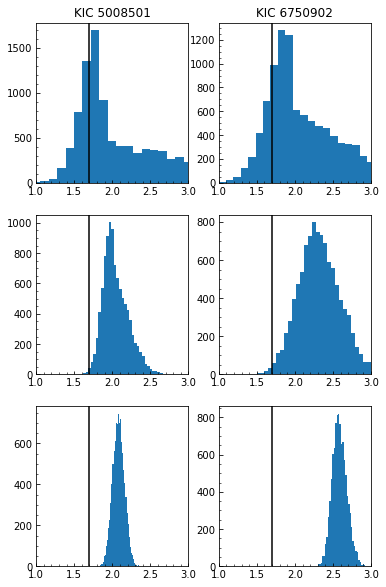

In [37]:
#1 is KOI 3980 2 is 1666
e_depth_1=[11,-10]
e_rstar_Huber_1=[0.36, -0.14]
e_rstar_CKS_1=[.15,.13]
e_rstar_Brewer_1=[0.05, -0.04]

e_depth_2=[9,-9]
e_rstar_Huber_2=[0.63,-.15]
e_rstar_CKS_2=[.13,.07]
e_rstar_Brewer_2=[0.04, -0.04]

def rp_calc(rstar, e_rstar_up, e_rstar_dn, depth, e_depth_up, e_depth_dn):
    rstar*=(cons.R_sun).to('m')
    e_rstar_dn*=(cons.R_sun).to('m')
    e_rstar_up*=(cons.R_sun).to('m')
    flips=np.random.binomial(1, 0.5, 2)
    if flips[0]==0:
        r_ast=rstar-e_rstar_dn*np.abs(np.random.randn())
    else:
        r_ast=rstar+e_rstar_up*np.abs(np.random.randn())
    if flips[1]==0:
        t_depth=depth-e_depth_dn*np.abs(np.random.randn())
    else:
        t_depth=depth+e_depth_up*np.abs(np.random.randn())
    rp=np.sqrt(r_ast**2*t_depth/(10**6))/cons.R_earth
    return rp

KOI_1666_rp_Huber=pd.Series([rp_calc(1.20, 0.63, 0.15, 203, 9, 9).value for i in range(10000)])
KOI_1666_rp_CKS=pd.Series([rp_calc(1.29, 0.13, 0.07, 203, 9, 9).value for i in range(10000)])
KOI_1666_rp_Brewer=pd.Series([rp_calc(1.34, 0.04, 0.04, 203, 9, 9).value for i in range(10000)])

KOI_3980_rp_Huber=pd.Series([rp_calc(1.01, 0.36, 0.14, 316, 11, 10).value for i in range(10000)])
KOI_3980_rp_CKS=pd.Series([rp_calc(1.19, 0.15, 0.13, 316, 11, 10).value for i in range(10000)])
KOI_3980_rp_Brewer=pd.Series([rp_calc(1.33, 0.05, 0.04, 316, 11, 10).value for i in range(10000)])

frac_1666_Huber=len(KOI_1666_rp_Huber[KOI_1666_rp_Huber<1.7])/len(KOI_1666_rp_Huber)
frac_1666_CKS=len(KOI_1666_rp_CKS[KOI_1666_rp_CKS<1.7])/len(KOI_1666_rp_CKS)
frac_1666_Brewer=len(KOI_1666_rp_Brewer[KOI_1666_rp_Brewer<1.7])/len(KOI_1666_rp_Brewer)

frac_3980_Huber=len(KOI_3980_rp_Huber[KOI_3980_rp_Huber<1.7])/len(KOI_3980_rp_Huber)
frac_3980_CKS=len(KOI_3980_rp_CKS[KOI_3980_rp_CKS<1.7])/len(KOI_3980_rp_CKS)
frac_3980_Brewer=len(KOI_3980_rp_Brewer[KOI_3980_rp_Brewer<1.7])/len(KOI_3980_rp_Brewer)

f, ax = plt.subplots(ncols=2, nrows=3, figsize=(6,10))
ax[0][0].hist(KOI_1666_rp_Huber.values, bins=40)
ax[1][0].hist(KOI_1666_rp_CKS.values, bins=40)
ax[2][0].hist(KOI_1666_rp_Brewer.values, bins=40)
ax[0][1].hist(KOI_3980_rp_Huber.values, bins=40)
ax[1][1].hist(KOI_3980_rp_CKS.values, bins=40)
ax[2][1].hist(KOI_3980_rp_Brewer.values, bins=40)
for axis in ax:
    for a in axis:
        a.set_xlim(1,3)
        a.axvline(x=1.7,c='k')
ax[0][0].set_title('KIC 5008501')
ax[0][1].set_title('KIC 6750902')
        
print(frac_1666_Huber, frac_1666_CKS, frac_1666_Brewer, frac_3980_Huber, frac_3980_CKS, frac_3980_Brewer)

In [38]:
uspbrewer.columns.values

array(['designation', 'coord1', 'coord2', 'ra', 'ra_error', 'dec',
       'dec_error', 'parallax', 'parallax_error', 'parallax_over_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'visibility_periods_used', 'mean_varpi_factor_al',
       'rv_nb_transits', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
       'radial_velocity', 'radial_velocity_error', 'phot_variable_flag',
       'l', 'b', 'distance', 'r_lo', 'r_hi', 'ra_prop', 'dec_prop',
       'Group', 'KIC', 'KOI', 'Kpmag', 'Teff', 'E_Teff', 'e_teff_lc',
       'logg', 'E_logg

In [39]:
mr_relation=pd.read_csv('Data/massradiusEarthlikeRocky.txt', header=None,names=['Mass','Radius'], delimiter='\t')

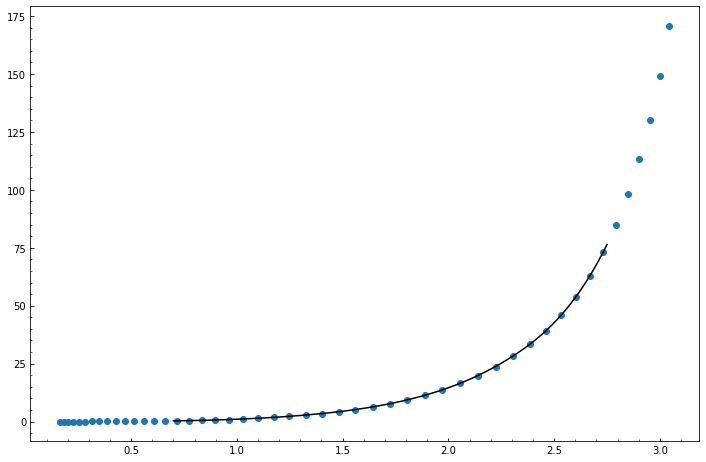

In [40]:
from scipy.interpolate import UnivariateSpline
mr_spline=UnivariateSpline(mr_relation.Radius, mr_relation.Mass)
mr_spline.set_smoothing_factor(1)
f,ax=plt.subplots(1,figsize=(12,8))
radii=np.linspace(sousps.Rp.min(), sousps.Rp.max(),150)
plt.scatter(mr_relation.Radius, mr_relation.Mass)
plt.plot(radii, mr_spline(radii),c='k')

In [41]:
uspbrewer['Mp_Huber']=mr_spline(uspbrewer['Rp_Huber'])
uspbrewer['Mp_CKS']=mr_spline(uspbrewer['Rp_CKS'])
uspbrewer['Mp_Brewer']=mr_spline(uspbrewer['Rp_Brewer'])

In [187]:
len(hjs.loc[hjs.pl_bmassj>2.68])

44

In [42]:
#uspbrewer.loc[(uspbrewer.Rp_Huber>1.7)&(uspbrewer.Rp_CKS>1.7)&(uspbrewer.Rp_Brewer>1.7), ['pl_hostname','R_star_Huber','Rp_Huber','R_star_CKS','Rp_CKS','R_star_Brewer','Rp_Brewer', 'pl_orbper', '[Fe/H]', 'Mp_Huber','Mp_CKS','Mp_Brewer','Teff','phot_g_mean_mag','designation']]

In [43]:
lower_brewer_Rp=[]
upper_brewer_Rp=[]

lower_brewer_Mp=[]
upper_brewer_Mp=[]

uspbrewer.Rad=uspbrewer.Rad.astype(float)
uspbrewer.b_Rad=uspbrewer.b_Rad.astype(float)
uspbrewer.B_Rad=uspbrewer.B_Rad.astype(float)

for i, sys in uspbrewer.iterrows():
    planet_radii = [rp_calc(sys.Rad, sys.Rad-sys.b_Rad, sys.B_Rad-sys.Rad, sys.Depth, sys.e_depth_lc, sys.E_Depth).value for i in range(1000)]
    planet_masses = mr_spline(planet_radii)
    lower_brewer_Rp.append(np.percentile(planet_radii, 16))
    upper_brewer_Rp.append(np.percentile(planet_radii, 84))
    lower_brewer_Mp.append(np.percentile(planet_masses, 16))
    upper_brewer_Mp.append(np.percentile(planet_masses, 84))
    
uspbrewer['b_Rp_Brewer'] = lower_brewer_Rp
uspbrewer['B_Rp_Brewer'] = upper_brewer_Rp
uspbrewer['b_Mp_Brewer'] = lower_brewer_Mp
uspbrewer['B_Mp_Brewer'] = upper_brewer_Mp

uspbrewer['e_Rp_Brewer'] = uspbrewer['Rp_Brewer']-uspbrewer['b_Rp_Brewer']
uspbrewer['E_Rp_Brewer'] = uspbrewer['B_Rp_Brewer']-uspbrewer['Rp_Brewer']
uspbrewer['e_Mp_Brewer'] = uspbrewer['Mp_Brewer']-uspbrewer['b_Mp_Brewer']
uspbrewer['E_Mp_Brewer'] = uspbrewer['B_Mp_Brewer']-uspbrewer['Mp_Brewer']

In [44]:
uspbrewer.columns.values

array(['designation', 'coord1', 'coord2', 'ra', 'ra_error', 'dec',
       'dec_error', 'parallax', 'parallax_error', 'parallax_over_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'visibility_periods_used', 'mean_varpi_factor_al',
       'rv_nb_transits', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
       'radial_velocity', 'radial_velocity_error', 'phot_variable_flag',
       'l', 'b', 'distance', 'r_lo', 'r_hi', 'ra_prop', 'dec_prop',
       'Group', 'KIC', 'KOI', 'Kpmag', 'Teff', 'E_Teff', 'e_teff_lc',
       'logg', 'E_logg

In [52]:
ktcgaia.to_csv('Data/04_28_2020_ktcgaia.csv')
uspbrewer.to_csv('Data/04_28_2020_uspbrewer.csv')
ktcgaia_gd=GaiaData('Data/04_28_2020_ktcgaia.csv')
uspbrewer_gd=GaiaData('Data/04_28_2020_uspbrewer.csv')

In [162]:
def gaia_uncertainties(df, df_fn):
    df.to_csv(df_fn)
    gd=GaiaData(df_fn)
    COV=gd.get_cov()
    rv_mask = ~np.isfinite(COV[:, 5, 5])
    COV[rv_mask, 5, 5] = 0.

    gdunits = dict()
    gdunits.setdefault('ra', unit.deg)
    gdunits.setdefault('dec', unit.deg)
    gdunits.setdefault('parallax', unit.mas)
    gdunits.setdefault('pmra', unit.mas/unit.yr)
    gdunits.setdefault('pmdec', unit.mas/unit.yr)
    gdunits.setdefault('radial_velocity', unit.km/unit.s)

    arrs = []
    for k, u in gdunits.items():
        print(k, u)
        arrs.append(getattr(gd,k).to_value(u))
    y = np.stack(arrs).T

    samples = np.array([np.random.multivariate_normal(y[i], COV[i], size=100)
                        for i in range(len(y))])
    d = gd.data.copy()
    for i, (k, u) in enumerate(gdunits.items()):
        d[k] = samples[..., i]*u
    d=GaiaData(d)

    c_samples = d.get_skycoord()
    galcen = c_samples.transform_to(coord.Galactocentric)

    df['gal_U_error']=np.std(galcen.v_x, axis=1).value
    df['gal_V_error']=np.std(galcen.v_y, axis=1).value
    df['gal_W_error']=np.std(galcen.v_z, axis=1).value

    return df

In [180]:
uspbrewer_errs=gaia_uncertainties(uspbrewer, 'Data/04_28_2020_uspbrewer.csv')
uspctrl=control_sample(uspbrewer, ktcgaia.loc[~ktcgaia.gal_U.isnull()])
uspctrl_errs=gaia_uncertainties(uspctrl,'Data/04_28_2020_uspbrewer_ctrl.csv')

hjs=gaia_uncertainties(hjs,'Data/04_28_2020_hj.csv')
hjctrl=control_sample_hjs(hjs, gaiahjs)
hjctrl=gaia_uncertainties(hjctrl,'Data/04_28_2020_hj_ctrl.csv')

ra deg
dec deg
parallax mas
pmra mas / yr
pmdec mas / yr
radial_velocity km / s


ra deg
dec deg
parallax mas
pmra mas / yr
pmdec mas / yr
radial_velocity km / s
ra deg
dec deg
parallax mas
pmra mas / yr
pmdec mas / yr
radial_velocity km / s
ra deg
dec deg
parallax mas
pmra mas / yr
pmdec mas / yr
radial_velocity km / s


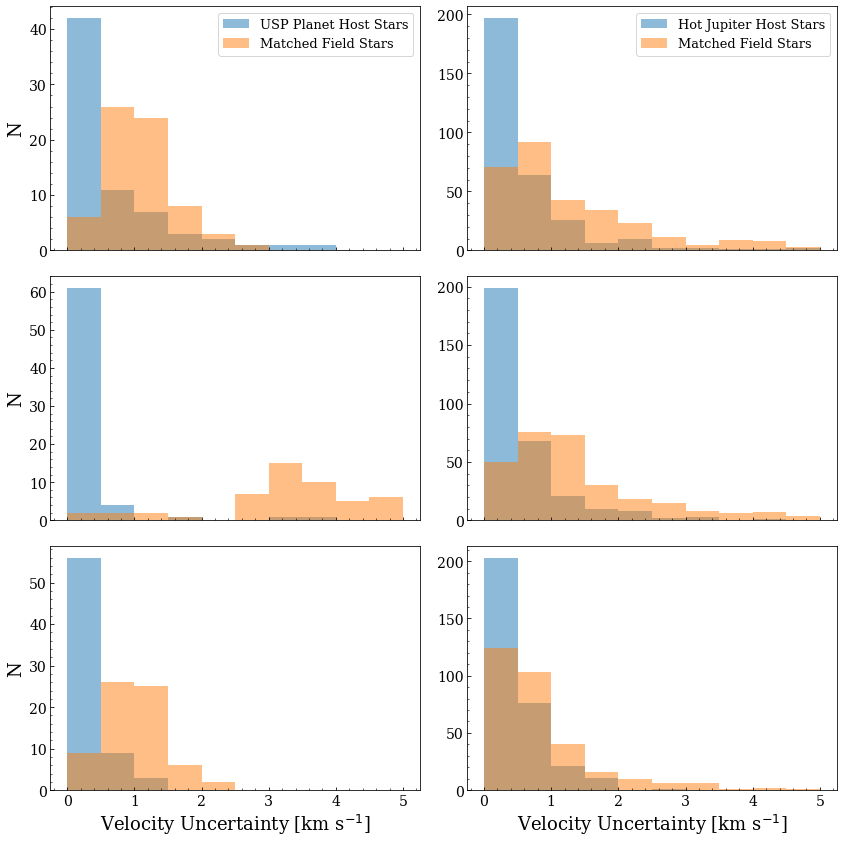

In [181]:
font={'size':16, 'family':'serif'}
plt.rc('font',**font)

f, ax=plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex=True)
ax[0][1].hist(hjs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Hot Jupiter Host Stars')
ax[1][1].hist(hjs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist(hjs.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][1].hist(hjctrl.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][1].hist(hjctrl.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist(hjctrl.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][0].hist(uspbrewer_errs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='USP Planet Host Stars')
ax[1][0].hist(uspbrewer_errs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist(uspbrewer_errs.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][0].hist(uspctrl_errs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][0].hist(uspctrl_errs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist(uspctrl_errs.gal_W_error, alpha=0.5, bins=10, range=(0,5))


ax[2][0].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[2][1].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[0][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[1][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[2][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[0][1].legend(fontsize=13)
ax[0][0].legend(fontsize=13)
for a in ax:
    for axis in a:
        axis.tick_params(axis='x', labelsize=14)
        axis.tick_params(axis='y', labelsize=14)
f.tight_layout()
plt.savefig('PaperPlots/velocity_uncertainties.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/velocity_uncertainties.pdf',bbox_inches='tight')

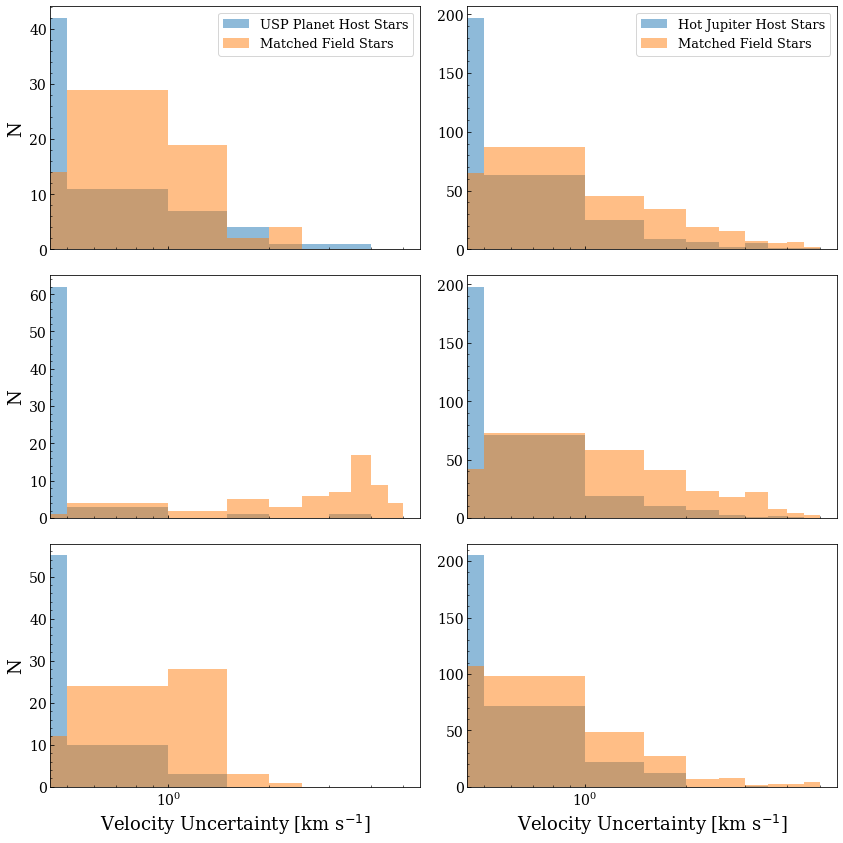

In [169]:
font={'size':16, 'family':'serif'}
plt.rc('font',**font)

f, ax=plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex=True)
ax[0][1].hist(hjs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Hot Jupiter Host Stars')
ax[1][1].hist(hjs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist(hjs.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][1].hist(hjctrl.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][1].hist(hjctrl.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist(hjctrl.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][0].hist(uspbrewer_errs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='USP Planet Host Stars')
ax[1][0].hist(uspbrewer_errs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist(uspbrewer_errs.gal_W_error, alpha=0.5, bins=10, range=(0,5))

ax[0][0].hist(uspctrl_errs.gal_U_error, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][0].hist(uspctrl_errs.gal_V_error, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist(uspctrl_errs.gal_W_error, alpha=0.5, bins=10, range=(0,5))


ax[2][0].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[2][1].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[0][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[1][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[2][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[0][1].legend(fontsize=13)
ax[0][0].legend(fontsize=13)
for a in ax:
    for axis in a:
        axis.tick_params(axis='x', labelsize=14)
        axis.tick_params(axis='y', labelsize=14)
        axis.set_xscale('log')
f.tight_layout()
plt.savefig('PaperPlots/velocity_uncertainties_logxscale.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/velocity_uncertainties_logxscale.pdf',bbox_inches='tight')

In [176]:
def uvw_uncertainty(sys):
    ras=sys.ra+sys.ra_error*np.random.randn(100)
    decs=sys.dec+sys.dec_error*np.random.randn(100)
    parallaxes=sys.parallax+sys.parallax_error*np.random.randn(100)
    pmracosdecs=sys.pmra+sys.pmra_error*np.random.randn(100)
    pmdecs=sys.pmdec+sys.pmdec_error*np.random.randn(100)
    if sys.rv_source=='Petigura':
        rvs=sys.radial_velocity+0.1*np.random.randn(100)
    elif sys.rv_source=='LAMOST':
        rvs=sys.radial_velocity+5*np.random.randn(100)
    elif sys.rv_source=='APOGEE':
        rvs=sys.radial_velocity+1*np.random.randn(100)
    elif sys.rv_source=='Gaia':
        rvs=sys.radial_velocity+sys.radial_velocity_error*np.random.randn(100)
    else: 
        rvs=sys.radial_velocity+1*np.random.randn(100)

    #Petigura .1 km/s rv uncertainty
    skycoords = SkyCoord(ra=ras*unit.deg,dec=decs*unit.deg,
                     distance=(1000/parallaxes)*unit.pc,
                     pm_ra_cosdec=pmracosdecs*unit.mas/unit.yr,pm_dec=pmdecs*unit.mas/unit.yr,
                     radial_velocity=rvs*unit.km/unit.s)
    galcen = skycoords.transform_to(Galactocentric)
    b_U, U, B_U = np.percentile(galcen.v_x.value, [16,50,84])
    b_V, V, B_V = np.percentile(galcen.v_y.value, [16,50,84])
    b_W, W, B_W = np.percentile(galcen.v_z.value, [16,50,84])
    return b_U, U, B_U, b_V, V, B_V, b_W, W, B_W
def uvw_uncertainty_hjs(sys, hjs):
    ras=sys.ra+sys.ra_error*np.random.randn(100)
    decs=sys.dec+sys.dec_error*np.random.randn(100)
    parallaxes=sys.parallax+sys.parallax_error*np.random.randn(100)
    pmracosdecs=sys.pmra+sys.pmra_error*np.random.randn(100)
    pmdecs=sys.pmdec+sys.pmdec_error*np.random.randn(100)
    if ~np.isnan(sys.radial_velocity_error):
        rvs=sys.radial_velocity+sys.radial_velocity_error*np.random.randn(100)
    else:
        rvs=sys.radial_velocity+hjs.radial_velocity_error.median()*np.random.randn(100)
    #Petigura .1 km/s rv uncertainty
    skycoords = SkyCoord(ra=ras*unit.deg,dec=decs*unit.deg,
                     distance=(1000/parallaxes)*unit.pc,
                     pm_ra_cosdec=pmracosdecs*unit.mas/unit.yr,pm_dec=pmdecs*unit.mas/unit.yr,
                     radial_velocity=rvs*unit.km/unit.s)
    galcen = skycoords.transform_to(Galactocentric)
    b_U, U, B_U = np.percentile(galcen.v_x.value, [16,50,84])
    b_V, V, B_V = np.percentile(galcen.v_y.value, [16,50,84])
    b_W, W, B_W = np.percentile(galcen.v_z.value, [16,50,84])
    return b_U, U, B_U, b_V, V, B_V, b_W, W, B_W
def df_uncertainties(df):
    bUs, Us, BUs, bVs, Vs, BVs, bWs, Ws, BWs = [], [], [], [], [], [], [], [], []
    for i, sys in df.iterrows():
        bU, U, BU, bV, V, BV, bW, W, BW = uvw_uncertainty(sys)
        bUs.append(bU)
        BUs.append(BU)
        bVs.append(bV)
        BVs.append(BV)
        bWs.append(bW)
        BWs.append(BW)
        Us.append(U)
        Vs.append(V)
        Ws.append(W)
    bUs, Us, BUs, bVs, Vs, BVs, bWs, Ws, BWs = np.array(bUs), \
    np.array(Us), np.array(BUs), np.array(bVs), np.array(Vs), np.array(BVs)\
    , np.array(bWs), np.array(Ws), np.array(BWs)    
    df['e_gal_U']=Us-bUs
    df['E_gal_U']=BUs-Us
    df['e_gal_V']=Vs-bVs
    df['E_gal_V']=BVs-Vs
    df['e_gal_W']=Ws-bWs
    df['E_gal_W']=BWs-Ws
    return df
def df_uncertainties_hjs(df):
    bUs, Us, BUs, bVs, Vs, BVs, bWs, Ws, BWs = [], [], [], [], [], [], [], [], []
    for i, sys in df.iterrows():
        bU, U, BU, bV, V, BV, bW, W, BW = uvw_uncertainty_hjs(sys, df)
        bUs.append(bU)
        BUs.append(BU)
        bVs.append(bV)
        BVs.append(BV)
        bWs.append(bW)
        BWs.append(BW)
        Us.append(U)
        Vs.append(V)
        Ws.append(W)
    bUs, Us, BUs, bVs, Vs, BVs, bWs, Ws, BWs = np.array(bUs), \
    np.array(Us), np.array(BUs), np.array(bVs), np.array(Vs), np.array(BVs)\
    , np.array(bWs), np.array(Ws), np.array(BWs)    
    df['e_gal_U']=Us-bUs
    df['E_gal_U']=BUs-Us
    df['e_gal_V']=Vs-bVs
    df['E_gal_V']=BVs-Vs
    df['e_gal_W']=Ws-bWs
    df['E_gal_W']=BWs-Ws
    return df

In [177]:
uspbrewer=df_uncertainties(uspbrewer)
hjs=df_uncertainties_hjs(hjs)

uspctrl=control_sample(uspbrewer, ktcgaia.loc[~ktcgaia.gal_U.isnull()])
uspctrl=df_uncertainties(uspctrl)

hjctrl=control_sample_hjs(hjs, gaiahjs)
hjctrl=df_uncertainties_hjs(hjctrl)

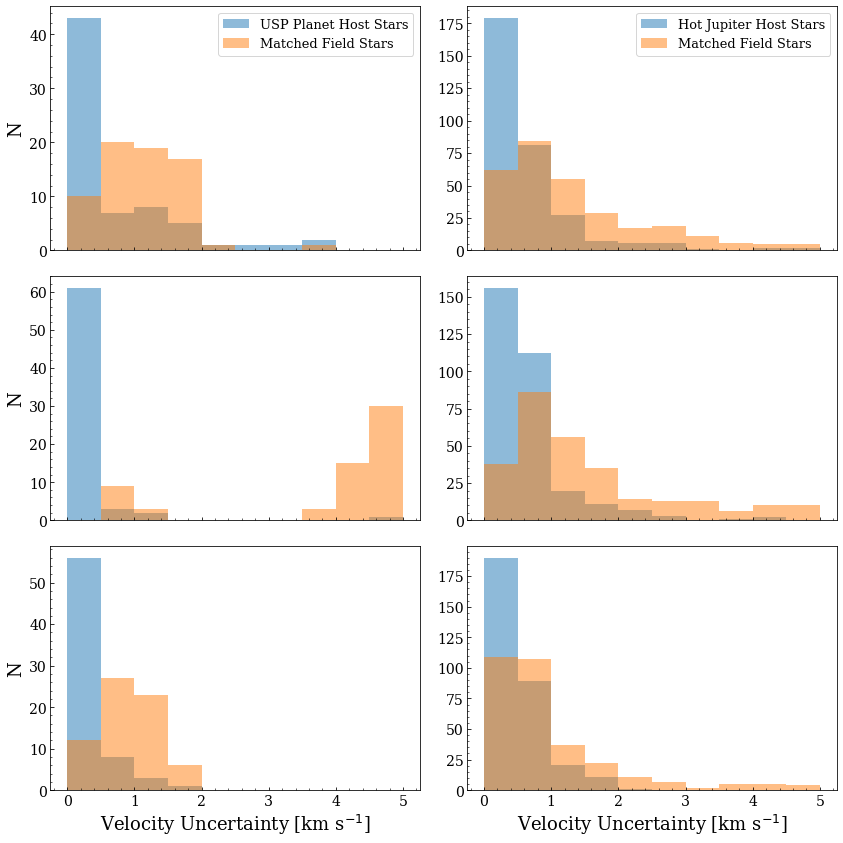

In [178]:
font={'size':16, 'family':'serif'}
plt.rc('font',**font)

f, ax=plt.subplots(ncols=2, nrows=3, figsize=(12, 12), sharex=True)
ax[0][1].hist((hjs.e_gal_U+hjs.E_gal_U)/2, alpha=0.5, bins=10, range=(0,5), label='Hot Jupiter Host Stars')
ax[1][1].hist((hjs.e_gal_V+hjs.E_gal_V)/2, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist((hjs.e_gal_W+hjs.E_gal_W)/2, alpha=0.5, bins=10, range=(0,5))
ax[0][1].hist((hjctrl.e_gal_U+hjctrl.E_gal_U)/2, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][1].hist((hjctrl.e_gal_V+hjctrl.E_gal_V)/2, alpha=0.5, bins=10, range=(0,5))
ax[2][1].hist((hjctrl.e_gal_W+hjctrl.E_gal_W)/2, alpha=0.5, bins=10, range=(0,5))
ax[0][0].hist((uspbrewer.e_gal_U+uspbrewer.E_gal_U)/2, alpha=0.5, bins=10, range=(0,5), label='USP Planet Host Stars')
ax[1][0].hist((uspbrewer.e_gal_V+uspbrewer.E_gal_V)/2, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist((uspbrewer.e_gal_W+uspbrewer.E_gal_W)/2, alpha=0.5, bins=10, range=(0,5))
ax[0][0].hist((uspctrl.e_gal_U+uspctrl.E_gal_U)/2, alpha=0.5, bins=10, range=(0,5), label='Matched Field Stars')
ax[1][0].hist((uspctrl.e_gal_V+uspctrl.E_gal_V)/2, alpha=0.5, bins=10, range=(0,5))
ax[2][0].hist((uspctrl.e_gal_W+uspctrl.E_gal_W)/2, alpha=0.5, bins=10, range=(0,5))
ax[2][0].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[2][1].set_xlabel('Velocity Uncertainty [km s$^{-1}$]', fontsize=18, fontfamily='serif')
ax[0][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[1][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[2][0].set_ylabel('N', fontsize=18, fontfamily='serif')
ax[0][1].legend(fontsize=13)
ax[0][0].legend(fontsize=13)
for a in ax:
    for axis in a:
        axis.tick_params(axis='x', labelsize=14)
        axis.tick_params(axis='y', labelsize=14)
f.tight_layout()
plt.savefig('PaperPlots/velocity_uncertainties.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/velocity_uncertainties.pdf',bbox_inches='tight')

In [179]:
print(uspbrewer.sort_values(by='ra')[['KIC','gaia_id','radial_velocity','pl_orbper','Rp_Brewer','e_Rp_Brewer','E_Rp_Brewer','Mp_Brewer','e_Mp_Brewer','E_Mp_Brewer']][0:10].to_latex())

\begin{tabular}{lrlrrrrrrrr}
\toprule
{} &       KIC &                       gaia\_id &  radial\_velocity &  pl\_orbper &  Rp\_Brewer &  e\_Rp\_Brewer &  E\_Rp\_Brewer &  Mp\_Brewer &  e\_Mp\_Brewer &  E\_Mp\_Brewer \\
\midrule
42 &  6750902 &  Gaia DR2 2116704610985856512 & -17.00 &  0.469332 &  2.578849 &  0.105614 &  0.091515 &  50.935566 &  10.721943 &  12.178795 \\
44 &  10186945 &  Gaia DR2 2119583510383666560 & -12.60 &  0.396830 &  1.095080 &  0.031552 &  0.015886 &  1.394309 &  0.142656 &  0.076101 \\
45 &  10319385 &  Gaia DR2 2119593990103923840 & -38.40 &  0.689209 &  1.610925 &  0.031411 &  0.016859 &  5.855813 &  0.438110 &  0.248141 \\
43 &  9873254 &  Gaia DR2 2119511080054847616 & -8.10 &  0.900370 &  0.801384 &  0.040031 &  0.037442 &  0.444408 &  0.073813 &  0.079295 \\
35 &  6666233 &  Gaia DR2 2104748521545492864 & -51.43 &  0.512409 & NaN & NaN & NaN & NaN & NaN & NaN \\
41 &  10647452 &  Gaia DR2 2107681262654003328 & -15.60 &  0.762951 &  1.270697 &  0.074613 & 

# Use above cell to construct table with uncertainties

Petigura doesn't have RV uncertainties

SO Orbital Periods don't have uncertainty



In [ ]:
uspbrewer.columns.values

In [ ]:
def RV_signal(mp, p): 
    mp_kg=mp*cons.M_earth 
    mp_Jup=mp_kg/cons.M_jup 
    p=p*unit.day 
    P_yr=p.to('yr')/unit.yr 
    return 28.4*mp_Jup*(P_yr**(-1/3))
                                                                                                                                                                     
print(RV_signal(12.7, 0.96))                                                                                                                                                

print(RV_signal(17.5, 0.96))                                                                                                                                                 

print(RV_signal(14.58, 0.46))                                                                                                                                               

print(RV_signal(50, 0.46))                                                                                                                                                 


In [ ]:
sousps.rv_source.values

In [ ]:
# contaminants=dict()
# for designation in sousps.designation:
    
#     ra=sousps.loc[sousps.designation==designation, 'ra'].values[0]
#     dec=sousps.loc[sousps.designation==designation, 'dec'].values[0]
#     query="SELECT DISTANCE(POINT('ICRS', ra, dec),POINT('ICRS',"+str(ra)+", "+str(dec)+"))/3600 AS dist, designation, phot_g_mean_mag FROM gaiadr2.gaia_source WHERE 1=CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', "+str(ra)+", "+str(dec)+", 0.00111111111)) ORDER BY dist ASC"
#     gaiajob = Gaia.launch_job(query)
#     gaiajob = gaiajob.get_data()
#     gaiajob = gaiajob.to_pandas()
#     gaiajob.designation=gaiajob.designation.str.decode('utf-8')
#     gaiajob=gaiajob.loc[gaiajob.designation!=designation]
#     if len(gaiajob.designation)>0:
#         print(sousps.loc[sousps.designation==designation, 'source'])
#         contaminants[designation]=gaiajob.designation
# contaminants

In [ ]:
# multirv=(~sousps.APOGEE_radial_velocity.isnull()|~sousps.LAMOST_radial_velocity.isnull())|~sousps.petigura_radial_velocity.isnull()
# sousps.loc[multirv, ['gaia_rv','LAMOST_radial_velocity','petigura_radial_velocity', 'APOGEE_radial_velocity']]

In [ ]:
t_MS_solar=10**10*unit.yr
uspbrewer['t_MS']=(uspbrewer['Mstar']**-2.5)*t_MS_solar #http://astronomy.swin.edu.au/cosmos/m/main+sequence+lifetime
uspbrewer['Mp']=mr_spline(uspbrewer['Rp'])
uspbrewer['Q_Lai']=(13/2)*uspbrewer['t_MS']*(9/2)*((uspbrewer.Mp*cons.M_earth)/(uspbrewer['Mstar']*cons.M_sun))*\
((uspbrewer['st_radius']*unit.m)/(uspbrewer['pl_orbsmax']*cons.au))**5*(2*np.pi/(uspbrewer.pl_orbper*unit.day.to('yr')))

bhasq=~uspbrewer['Q_Lai'].isnull()
bmeanp=uspbrewer.loc[bhasq, 'pl_orbper'].median()
bstdp=uspbrewer.loc[bhasq, 'pl_orbper'].std()
bpgreater=uspbrewer.pl_orbper>(bmeanp-bstdp)
bpless=uspbrewer.pl_orbper<(bmeanp+bstdp)
binstd=(bpgreater&bpless)&bhasq
bmedq=np.log10(uspbrewer.loc[binstd, 'Q_Lai'].median())
#stdmq=np.log10(np.percentile(uspbrewer.loc[instd, 'Q_Lai'], 16))
#stdpq=np.log10(np.percentile(uspbrewer.loc[instd, 'Q_Lai'], 84))
bstdmq=np.log10(np.percentile(uspbrewer.loc[binstd,'Q_Lai'], 16))
bstdpq=np.log10(np.percentile(uspbrewer.loc[binstd,'Q_Lai'], 84))
print(bstdmq,"$\ <\ \log_{10} Q_*\ <\ $",bstdpq)
print(bmedq, bstdpq-bmedq, bstdmq-bmedq)
print(len(uspbrewer.loc[~uspbrewer.Q_Lai.isnull()]))
font={'size':16}
plt.rc('font',**font)
f,ax=plt.subplots(figsize=(5,5))
plt.scatter(uspbrewer.loc[bhasq,'pl_orbper'],np.log10(uspbrewer.loc[bhasq,'Q_Lai']), marker='^',alpha=0.8,s=50, label='USP System')
plt.xlabel('Orbital Period [day]')
plt.ylabel("$\log_{10} Q_*$")
plt.axhline(y=bmedq, label='Median Q')
plt.axhspan(ymin=bstdmq, ymax=bstdpq, alpha=0.15)
plt.axvline(x=bmeanp, color='k', alpha=0.6, label='Median Period')
plt.axvspan(xmin=bmeanp-bstdp, xmax=bmeanp+bstdp, color='k', alpha=0.15)
plt.ylim(4,10)
plt.legend(fontsize=12, frameon=False)
ax=plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
ax.set_yticks([4,6,8,10])
plt.tight_layout()
plt.savefig('PaperPlots/Lai_Q_USP_LL_brewer.png', pad_inches=0)
plt.savefig('PaperPlots/Lai_Q_USP_LL_brewer.pdf', pad_inches=0)

In [ ]:
sousps_brewer=pd.merge(sousps, uspbrewer, on='pl_hostname')

In [ ]:
sousps_brewer.sort_values(by='Rp_x',ascending=False)[['pl_hostname','Rp_x','R__x','Rp_y','Rstar','Depth_x','pl_orbper_x']]

In [ ]:
sousps_brewer.loc[sousps_brewer.Rp_y>1.7,['pl_hostname','Rp_y','Depth_x','Rstar']]

In [ ]:
(sousps_brewer.R__x-sousps_brewer.Rstar).hist(bins=20)

In [ ]:
(sousps_brewer.Rp_x-sousps_brewer.Rp_y).hist(bins=20)

In [ ]:
(sousps_brewer.R__x-sousps_brewer.Rstar).describe(percentiles=np.arange(0,1.1,.1))

In [ ]:
len(uspbrewer), len(uspbrewer.loc[uspbrewer.Mstar<1.18])

In [ ]:
print(so_only_usps_ms.sort_values('ra').loc[~so_only_usps_ms.gal_U.isnull(), ['pl_hostname','designation', 'radial_velocity']][0:10].to_latex())

In [ ]:
so_only_usps_ms.loc[~so_only_usps_ms.gal_U.isnull(), 'rv_source'].unique()

In [ ]:
so_only_usps_ms.pl_orbper.median()

In [ ]:
f,ax=plt.subplots(ncols=2, nrows=1, figsize=(12,5))
ax[0].scatter(dr25usps.loc[dr25usps.source=='K2','bp_rp0'], dr25usps.loc[dr25usps.source=='K2','M_G0'],s=5,label='K2')
ax[0].scatter(dr25usps.loc[dr25usps.source=='Nonkep','bp_rp0'], dr25usps.loc[dr25usps.source=='Nonkep','M_G0'],s=5,label='Nonkep')
ax[0].scatter(dr25usps.loc[dr25usps.source=='DR25','bp_rp0'], dr25usps.loc[dr25usps.source=='DR25','M_G0'],s=5,label='DR25')
ax[0].set_ylim(10,2)
ax[0].legend()
ax[0].set_xlabel('$(G_{BP}-G_{RP})_0$')
ax[0].set_ylabel('$M_{G0}$')
ax[1].scatter(sousps.loc[sousps.source=='K2','bp_rp0'], sousps.loc[sousps.source=='K2','M_G0'],s=5,label='K2')
ax[1].scatter(sousps.loc[sousps.source=='Nonkep','bp_rp0'], sousps.loc[sousps.source=='Nonkep','M_G0'],s=5,label='Nonkep')
ax[1].scatter(sousps.loc[sousps.source=='SO','bp_rp0'], sousps.loc[sousps.source=='SO','M_G0'],s=5,label='SO')
ax[1].set_ylim(10,2)
ax[1].set_xlabel('$(G_{BP}-G_{RP})_0$')
ax[1].set_ylabel('$M_{G0}$')
ax[1].legend()

In [ ]:
f=plt.figure(figsize=(8,6))
plt.rcParams['font.size']=18
ax=f.add_subplot(111)
ax.scatter(so_only_usps_ms['bp_rp0'], so_only_usps_ms['M_G0'],s=15)
ax.set_ylim(13,3)
ax.set_xlabel('$(G_{BP}-G_{RP})_0$')
ax.set_ylabel('$M_{G0}$')
f.tight_layout()
f.savefig('SO_only_USPS_HRD.pdf')
f.savefig('SO_only_USPS_HRD.png', dpi=400)

In [ ]:
f,ax=all_sp_vel_scatter(dr25_usps_ms,match_zdistribution(dr25_usps_ms,ktcgaia))
f.savefig('PaperPlots/DR25USPVelocityEllipses.pdf',bbox_inches='tight')
f.savefig('PaperPlots/DR25USPVelocityEllipses.png',bbox_inches='tight')

In [ ]:
f,ax=all_sp_vel_scatter(so_usps_ms,match_zdistribution(so_usps_ms,ktcgaia))
f.savefig('PaperPlots/DR25USPVelocityEllipses.pdf',bbox_inches='tight')
f.savefig('PaperPlots/DR25USPVelocityEllipses.png',bbox_inches='tight')

In [ ]:
font={'size':16}
plt.rc('font',**font)
bins = (np.linspace(0.5, 2.6, 100),
        np.linspace(3, 12, 100))
H,xe,ye=np.histogram2d(gaiams.bp_rp0,gaiams.M_G0,bins=bins)
f,ax=plt.subplots(figsize=(5,5))
c=plt.pcolormesh(xe,ye,H.T,cmap='viridis',norm=mpl.colors.LogNorm(vmin=1E0, vmax=350))
plt.scatter(dr25_usps_ms.bp_rp0, dr25_usps_ms.M_G0, s=25, c='white',alpha=1, edgecolor='black', linewidth=1,label='USP Host')
plt.ylim(13,3)
plt.xlim(0.45,2.7)
tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
     0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
     2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
     2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
     2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
     2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
     3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
     3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
     3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
     7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
     9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
    10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
    10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
    11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
    11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
    12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
     0.        ],3)
spl2=UnivariateSpline._from_tck(tcks)
plt.plot(np.linspace(-0.05,2,100), spl2(np.linspace(-0.05,2,100)), label='Pleiades Main Sequence', c='orange', alpha=0.9)
plt.xlabel('$(G_{BP}-G_{RP})_0$')#, fontsize=34, weight='bold')
plt.ylabel('$M_{G0}$')#, fontsize=34, weight='bold')
plt.legend(fontsize=12, frameon=False)
ax.tick_params(direction='out')
ax.yaxis.set_tick_params(direction='in')
ax.xaxis.set_tick_params(direction='in')
cb=plt.colorbar(c,pad=0.01)
cb.set_label(label='Control Sample Stars')#,size=34, weight='bold')
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
plt.savefig('PaperPlots/dr25usp_gaiams_HR.pdf',bbox_inches='tight', pad_inches=0)
plt.savefig('PaperPlots/dr25usp_gaiams_HR.png',bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
font={'size':16}
plt.rc('font',**font)
bins = (np.linspace(0.5, 2, 100),
        np.linspace(3, 10, 100))
H,xe,ye=np.histogram2d(ktcgaia.bp_rp0,ktcgaia.M_G0,bins=bins)
f,ax=plt.subplots(figsize=(5,5))
c=plt.pcolormesh(xe,ye,H.T,cmap='viridis',norm=mpl.colors.LogNorm(vmin=1E0, vmax=350), zorder=0)
plt.ylim(10,3)
plt.xlim(0.45,2.05)
tcks=([-0.1533484 , -0.1533484 , -0.1533484 , -0.1533484 ,  0.63099294,
     0.96258741,  1.30771737,  1.71082406,  2.1444674 ,  2.4671927 ,
     2.5106812 ,  2.57087331,  2.61055761,  2.64182287,  2.65866666,
     2.66738897,  2.69233232,  2.70922952,  2.77087217,  2.82155137,
     2.84336095,  2.8537417 ,  2.89164453,  2.919838  ,  2.95142656,
     2.96471505,  2.98843198,  3.01530652,  3.04317003,  3.05686288,
     3.07316022,  3.10154062,  3.12891012,  3.16318994,  3.21736532,
     3.27362256,  3.3727818 ,  3.68525129,  3.68525129,  3.68525129,
     3.68525129],[-0.1745295 ,  2.3230733 ,  2.54252414,  5.54631992,  6.59988118,
     7.76297267,  8.59023705,  9.17519988,  9.65855025,  9.77533754,
     9.90392849, 10.05051825, 10.13809934, 10.19273253, 10.21350097,
    10.24293815, 10.38722777, 10.6498557 , 10.67855244, 10.68741252,
    10.71899853, 10.92565851, 10.97186376, 11.00763527, 11.08921082,
    11.27865818, 11.34078682, 11.34813415, 11.35886986, 11.42840745,
    11.55213609, 11.6855607 , 11.71061756, 12.12229352, 12.26016258,
    12.22448534, 12.8920296 ,  0.        ,  0.        ,  0.        ,
     0.        ],3)
spl2=UnivariateSpline._from_tck(tcks)
plt.plot(np.linspace(-0.05,2,100), spl2(np.linspace(-0.05,2,100)),zorder=1, label='Pleiades Main Sequence', c='orange', alpha=0.9)
plt.scatter(uspbrewer.bp_rp0, uspbrewer.M_G0, s=25, c='white',alpha=1,zorder=2, edgecolor='black', linewidth=1,label='USP Host')
plt.xlabel('$(G_{BP}-G_{RP})_0$')#, fontsize=34, weight='bold')
plt.ylabel('$M_{G0}$')#, fontsize=34, weight='bold')
plt.legend(fontsize=12, frameon=False)
ax.tick_params(direction='out')
ax.yaxis.set_tick_params(direction='in')
ax.xaxis.set_tick_params(direction='in')
cb=plt.colorbar(c,pad=0.01)
cb.set_label(label='Control Sample Stars')#,size=34, weight='bold')
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=18)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')
plt.savefig('PaperPlots/so_only_usp_gaiams_HR.pdf',bbox_inches='tight', pad_inches=0)
plt.savefig('PaperPlots/so_only_usp_gaiams_HR.png',bbox_inches='tight', pad_inches=0, dpi=300)

In [ ]:
len(pd.concat([so_usps_ms.designation, dr25_usps_ms.designation]).unique())

In [ ]:
dr25uspdev, dr25uspcontroldevs, dr25uspsamps=usp_vs_control_dispersion_hist(dr25_usps_ms, gaiams, mciters=1250)

In [ ]:
souspdev, souspcontroldevs, souspsamps=usp_vs_control_dispersion_hist(so_usps_ms, gaiams, mciters=2000)

In [ ]:
mcfile=open('SOUSPMonteCarloSaved.txt','w+')
mcfile.write('SOUSPdev='+str(souspdev)+'\n')
mcfile.close()
np.savetxt('SOUSPcontroldevs.txt',souspcontroldevs)

In [ ]:
font={'size':28}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16*.5))

ax.hist(souspcontroldevs, bins = 100)
ax.axvline(souspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(souspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(souspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(souspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(souspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]', size=28)
ax.set_ylabel('N', size=28)
ax.legend(fontsize=28, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(36,64,4))
ax.set_xlim(None, 65)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(souspcontroldevs2, bins = 100)
# ax[1].axvline(souspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/sousp_hist_presentation.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/sousp_hist_presentation.pdf',bbox_inches='tight')

In [ ]:
font={'size':16}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.1,7.1*.5))

ax.hist(souspcontroldevs, bins = 100)
ax.axvline(souspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(souspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(souspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(souspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(souspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(souspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]')
ax.set_ylabel('N')
ax.legend(fontsize=12, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(36,52,2))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(souspcontroldevs2, bins = 100)
# ax[1].axvline(souspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(souspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/sousp_combined_hist.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/sousp_combined_hist.pdf',bbox_inches='tight')

In [ ]:
print(len(uspcontroldevs[uspcontroldevs<uspdev])/len(uspcontroldevs)*100, ' %')

In [ ]:
so_only_uspdev, so_only_uspcontroldevs, so_only_uspsamps=usp_vs_control_dispersion_hist(so_only_usps_ms, ktcgaia, mciters=6000)

In [ ]:
font={'size':16}
plt.rc('font',**font)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.1,7.1*.5))

ax.hist(so_only_uspcontroldevs, bins = 100)
ax.axvline(so_only_uspdev, label = 'USP Hosts',lw=5, color='orange')
#plt.vlines(so_only_uspdev, ymin = 0, ymax = maxy, label = 'USP Total Dev', color = 'orange',lw=10)
ax.axvline(x = np.percentile(so_only_uspcontroldevs,50), label = 'Median', lw=3,color = 'k')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,16,), lw=3,color = 'k', linestyle = '--', label='$1 \sigma$')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,84), lw=3,color = 'k', linestyle = '--')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,2), lw=3,color = 'k', linestyle = ':', label='$2 \sigma$')
ax.axvline(x = np.percentile(so_only_uspcontroldevs,98), lw=3,color = 'k', linestyle = ':')
ax.set_xlabel('Sample Velocity Dispersion [km/s]')
ax.set_ylabel('N')
ax.legend(fontsize=12, frameon=False)
#ax.set_xlim(35.75,51)
ax.set_xticks(np.arange(34,74,4))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.tick_params(top=True, left=True, right=True, bottom=True, which='both')

# ax[1].hist(so_only_uspcontroldevs2, bins = 100)
# ax[1].axvline(so_only_uspdev2, label = 'Jupiter Hosts',lw=5, color='orange')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,50), label = 'Median', lw=3,color = 'k')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,16,), lw=3,color = 'k', linestyle = '--',label='$1 \sigma$')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,84), lw=3,color = 'k', linestyle = '--')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,2), lw=3,color = 'k', linestyle = ':',label='$2 \sigma$')
# ax[1].axvline(x = np.percentile(so_only_uspcontroldevs2,98), lw=3,color = 'k', linestyle = ':')
# ax[1].set_xlabel('Sample Velocity Dispersion [km/s]')
# ax[1].set_ylabel('N')
# ax[1].legend(fontsize=12, frameon=False)
# #ax[1].set_xlim(35.75,51)
# ax[1].set_xticks(np.arange(36,52,2))
# ax[1].yaxis.set_major_locator(MultipleLocator(100))
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].tick_params(top=True, left=True, right=True, bottom=True, which='both')
# plt.tight_layout()

plt.savefig('PaperPlots/so_only_usp_combined_hist.png',bbox_inches='tight', dpi=300)
plt.savefig('PaperPlots/so_only_usp_combined_hist.pdf',bbox_inches='tight')

In [ ]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(ktcgaia.gal_u, ktcgaia.gal_v, s=5)
ax.scatter(so_only_usps_ms.gal_u, so_only_usps_ms.gal_v, s=25)
ax.set_xlabel('u')
ax.set_ylabel('v')
ax=fig.add_subplot(132)
ax.scatter(ktcgaia.gal_u, ktcgaia.gal_w, s=5)
ax.scatter(so_only_usps_ms.gal_u, so_only_usps_ms.gal_w, s=25)
ax.set_xlabel('u')
ax.set_ylabel('w')
ax=fig.add_subplot(133)
ax.scatter(ktcgaia.gal_v, ktcgaia.gal_w, s=5)
ax.scatter(so_only_usps_ms.gal_v, so_only_usps_ms.gal_w, s=25)
ax.set_xlabel('v')
ax.set_ylabel('w')
plt.tight_layout()

In [ ]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
ax.scatter(ktcgaia.gal_U, ktcgaia.gal_V, s=5)
ax.scatter(so_only_usps_ms.gal_U, so_only_usps_ms.gal_V, s=25)
ax.set_xlabel('U')
ax.set_ylabel('V')
ax=fig.add_subplot(132)
ax.scatter(ktcgaia.gal_U, ktcgaia.gal_W, s=5)
ax.scatter(so_only_usps_ms.gal_U, so_only_usps_ms.gal_W, s=25)
ax.set_xlabel('U')
ax.set_ylabel('W')
ax=fig.add_subplot(133)
ax.scatter(ktcgaia.gal_V, ktcgaia.gal_W, s=5)
ax.scatter(so_only_usps_ms.gal_V, so_only_usps_ms.gal_W, s=25)
ax.set_xlabel('V')
ax.set_ylabel('W')
plt.tight_layout()

In [ ]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.scatter(ktcgaia.gal_V, np.sqrt(ktcgaia.gal_U**2+ktcgaia.gal_W**2), s=5, alpha=0.5)
ax.scatter(so_only_usps_ms.gal_V, np.sqrt(so_only_usps_ms.gal_U**2+so_only_usps_ms.gal_W**2), s=25)
ax.set_xlabel('V')
ax.set_ylabel('$(U^2+W^2)^{0.5}$')

In [ ]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.hist(ktcgaia.gal_w, density=True, alpha=0.5)
ax.hist(so_only_usps_ms.gal_w, density=True, alpha=0.5)